In [1]:
import os
import sys

notebook_path = os.path.abspath(".")
project_root = os.path.abspath(os.path.join(notebook_path, ".."))
os.chdir(project_root)

sys.path.append(os.path.join(project_root, "src"))

print(f"Current working directory: {project_root}")

Current working directory: /home/arian/deepLearning/del


In [2]:
import random
import shutil
import pickle
from glob import glob
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

from tqdm import tqdm
from tqdm.notebook import tqdm as notebook_tqdm

from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torchmetrics import Accuracy

import wandb

from src.utils import plot_training_curves

from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Subset
import numpy as np
import pickle
import os
import hashlib

# Image resizing test

## Dataset

Since there isn't any direct description what the dataset contains, which I downloaded here [Kaggle](https://www.kaggle.com/datasets/liusha249/imagenet10), I will first try to get an overview about my dataset.

In [3]:
data_dir = os.path.join(project_root, "data", "original")

class_names = sorted(os.listdir(data_dir))
print(f"Count of classes: {len(class_names)}")
print(f"Example class names: {class_names}")

Count of classes: 10
Example class names: ['Airliner', 'Airship', 'Container ship', 'King Penguin', 'Maltese dog', 'Orange (fruit)', 'Snow Leopard', 'Soccer ball', 'Sports car', 'Trailer truck']


### What do the class names present?

Those `n02056570` are so called `WNDIs` which are WordNet IDs - unique identifiers used by ImageNet to represent a specific synset (i.e., a group of synonymous words/meanings). Those aren't at all not human-readable, even if they map to actual objects.

To make training in the future easier, I will map these IDs to human-readable labels:

In [4]:
wnid_to_label = {
    "n02056570": "King Penguin",
    "n02085936": "Maltese dog",
    "n02128757": "Snow Leopard",
    "n02690373": "Airliner",
    "n02692877": "Airship",
    "n03095699": "Container ship",
    "n04254680": "Soccer ball",
    "n04285008": "Sports car",
    "n04467665": "Trailer truck",
    "n07747607": "Orange (fruit)"
}

In [5]:
# TODO: REMOVE THIS LATER
for wnid, label in wnid_to_label.items():
    label_path = os.path.join(data_dir, label)
    wnid_path = os.path.join(data_dir, wnid)
    if os.path.exists(label_path) and not os.path.exists(wnid_path):
        os.rename(label_path, wnid_path)

# Update class_names after renaming back
class_names = sorted(os.listdir(data_dir))
print(f"Renamed class folders back to WNIDs. New class names: {class_names}")

Renamed class folders back to WNIDs. New class names: ['n02056570', 'n02085936', 'n02128757', 'n02690373', 'n02692877', 'n03095699', 'n04254680', 'n04285008', 'n04467665', 'n07747607']


In [6]:
# Rename folders in data_dir from WNID to human-readable label
for wnid, label in wnid_to_label.items():
    old_path = os.path.join(data_dir, wnid)
    new_path = os.path.join(data_dir, label)
    if os.path.exists(old_path) and not os.path.exists(new_path):
        os.rename(old_path, new_path)

# Update class_names after renaming
class_names = sorted(os.listdir(data_dir))
print(f"Renamed class folders. New class names: {class_names}")


Renamed class folders. New class names: ['Airliner', 'Airship', 'Container ship', 'King Penguin', 'Maltese dog', 'Orange (fruit)', 'Snow Leopard', 'Soccer ball', 'Sports car', 'Trailer truck']


Let's dive deeper into the dataset. Now we will see how many images there are and how many per class.

In [7]:
image_counts = {}
for class_name in class_names:
    class_path = os.path.join(data_dir, class_name)
    num_images = len(os.listdir(class_path))
    image_counts[class_name] = num_images

print("Number of images per class:")
total_images = 0
for class_name, count in image_counts.items():
    print(f"{class_name}: {count}")
    total_images += count
print(f"Total number of images: {total_images}")

Number of images per class:
Airliner: 1300
Airship: 1300
Container ship: 1300
King Penguin: 1300
Maltese dog: 1300
Orange (fruit): 1300
Snow Leopard: 1300
Soccer ball: 1300
Sports car: 1300
Trailer truck: 1300
Total number of images: 13000


## Splitting


In [8]:
original_dir = os.path.join(project_root, "data", "original")
split_base_dir = os.path.join(project_root, "data", "split_data")

train_dir = os.path.join(split_base_dir, "train")
val_dir = os.path.join(split_base_dir, "val")
test_dir = os.path.join(split_base_dir, "test")

# Delete target directories and recreate them
for d in [train_dir, val_dir, test_dir]:
    if os.path.exists(d):
        shutil.rmtree(d)
    os.makedirs(d)

# Split-Ratios
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

class_names = sorted(os.listdir(original_dir))

for class_name in class_names:
    img_dir = os.path.join(original_dir, class_name)
    all_images = glob(os.path.join(img_dir, "*.JPEG"))

    train_imgs, temp_imgs = train_test_split(all_images, train_size=train_ratio, random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)  # each 10%

    for split, img_list in zip(
        [train_dir, val_dir, test_dir],
        [train_imgs, val_imgs, test_imgs]
    ):
        target_class_dir = os.path.join(split, class_name)
        os.makedirs(target_class_dir, exist_ok=True)
        for img in img_list:
            shutil.copy(img, os.path.join(target_class_dir, os.path.basename(img)))

print("Train/Val/Test split completed.")

Train/Val/Test split completed.


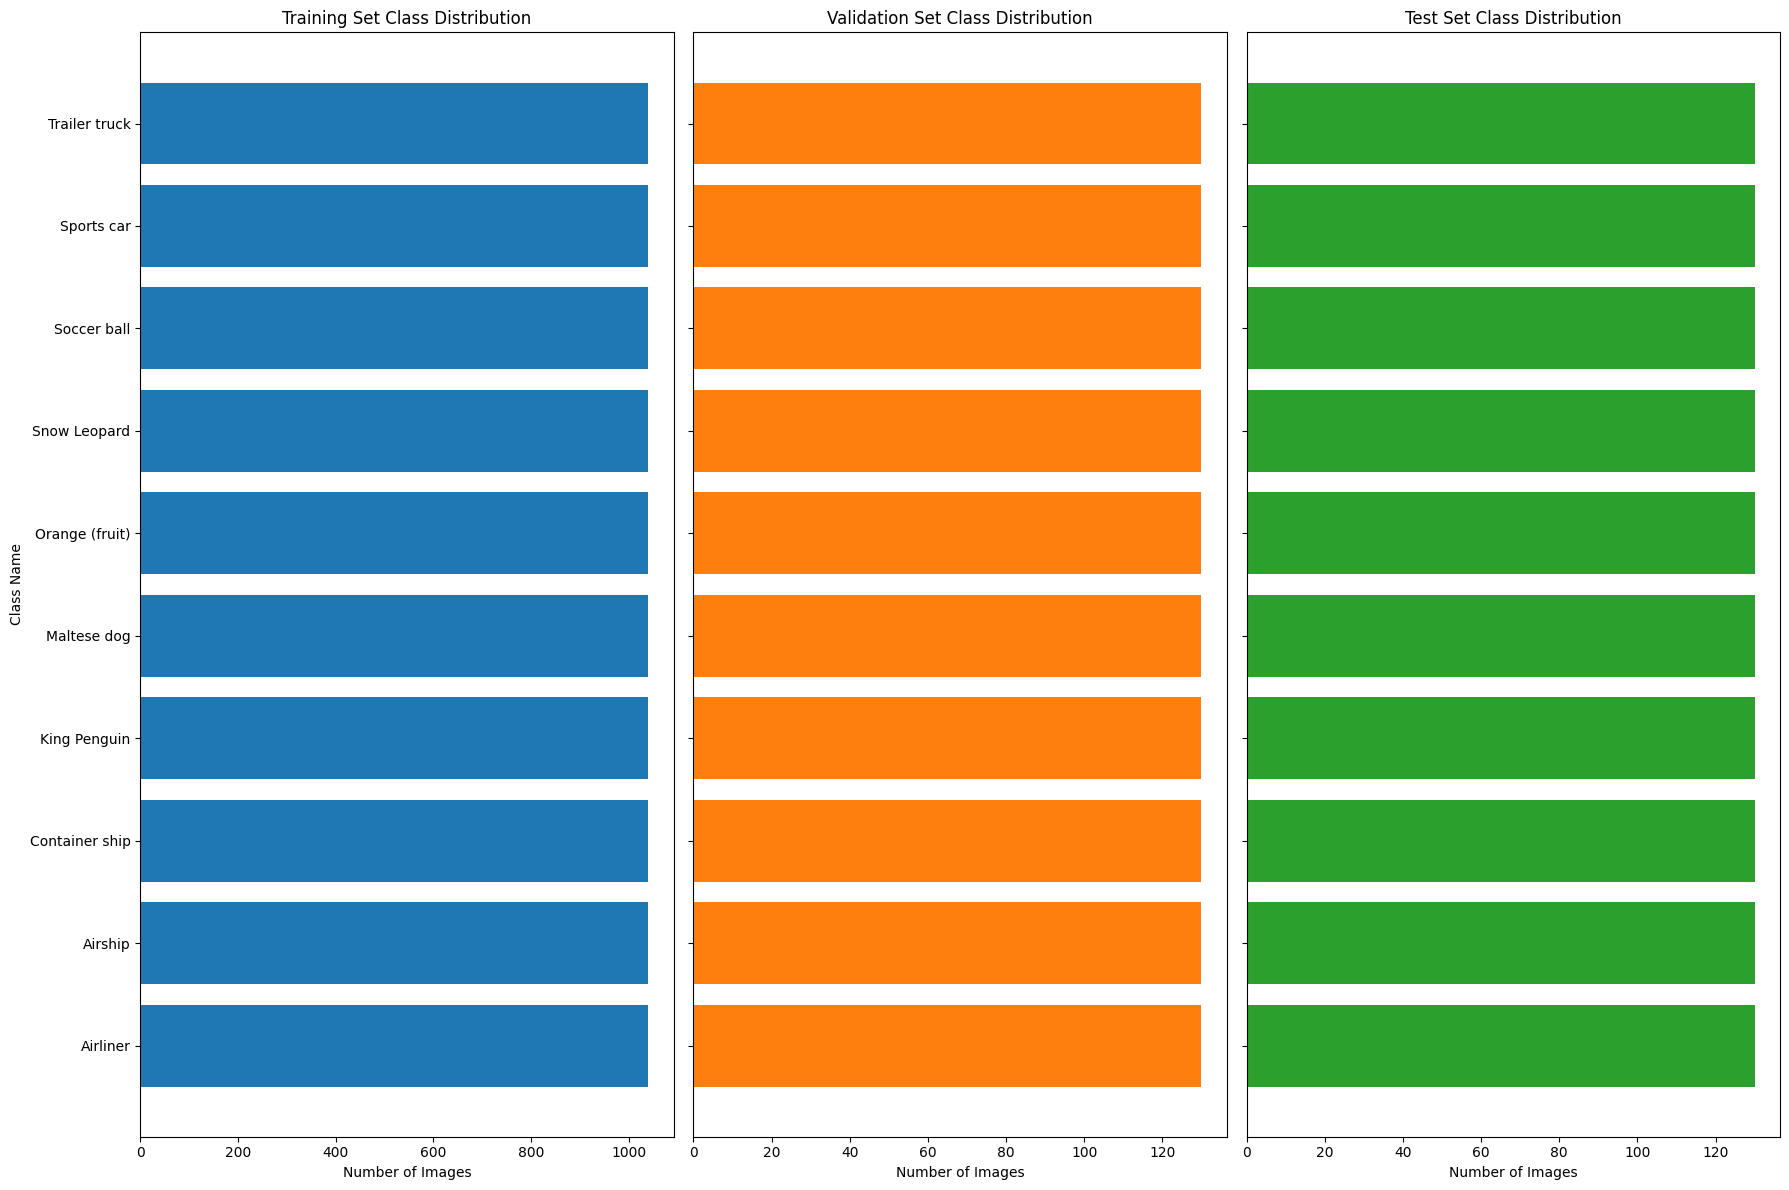

In [9]:
# Count images per class in each split
def count_images_per_class(split_dir):
    class_counts = {}
    for class_name in sorted(os.listdir(split_dir)):
        class_path = os.path.join(split_dir, class_name)
        if os.path.isdir(class_path):
            count = len([f for f in os.listdir(class_path) if f.endswith('.JPEG')])
            class_counts[class_name] = count
    return class_counts

train_counts = count_images_per_class(train_dir)
val_counts = count_images_per_class(val_dir)
test_counts = count_images_per_class(test_dir)

# Plotting with class names on the y-axis (horizontal bar plots)
fig, axs = plt.subplots(1, 3, figsize=(18, 12), sharey=True)

axs[0].barh(list(train_counts.keys()), list(train_counts.values()), color='tab:blue')
axs[0].set_title('Training Set Class Distribution')
axs[0].set_xlabel('Number of Images')
axs[0].set_ylabel('Class Name')

axs[1].barh(list(val_counts.keys()), list(val_counts.values()), color='tab:orange')
axs[1].set_title('Validation Set Class Distribution')
axs[1].set_xlabel('Number of Images')
# axs[1].set_ylabel('Class Name')  # Only set on first plot

axs[2].barh(list(test_counts.keys()), list(test_counts.values()), color='tab:green')
axs[2].set_title('Test Set Class Distribution')
axs[2].set_xlabel('Number of Images')
# axs[2].set_ylabel('Class Name')  # Only set on first plot

plt.tight_layout()
plt.show()


The class distribution across the training, validation, and test datasets is uniform, with each class containing an equal number of samples. This balanced distribution ensures that the model is trained and evaluated on an equal representation of all classes, reducing the risk of bias toward any specific class and supporting fair performance evaluation.

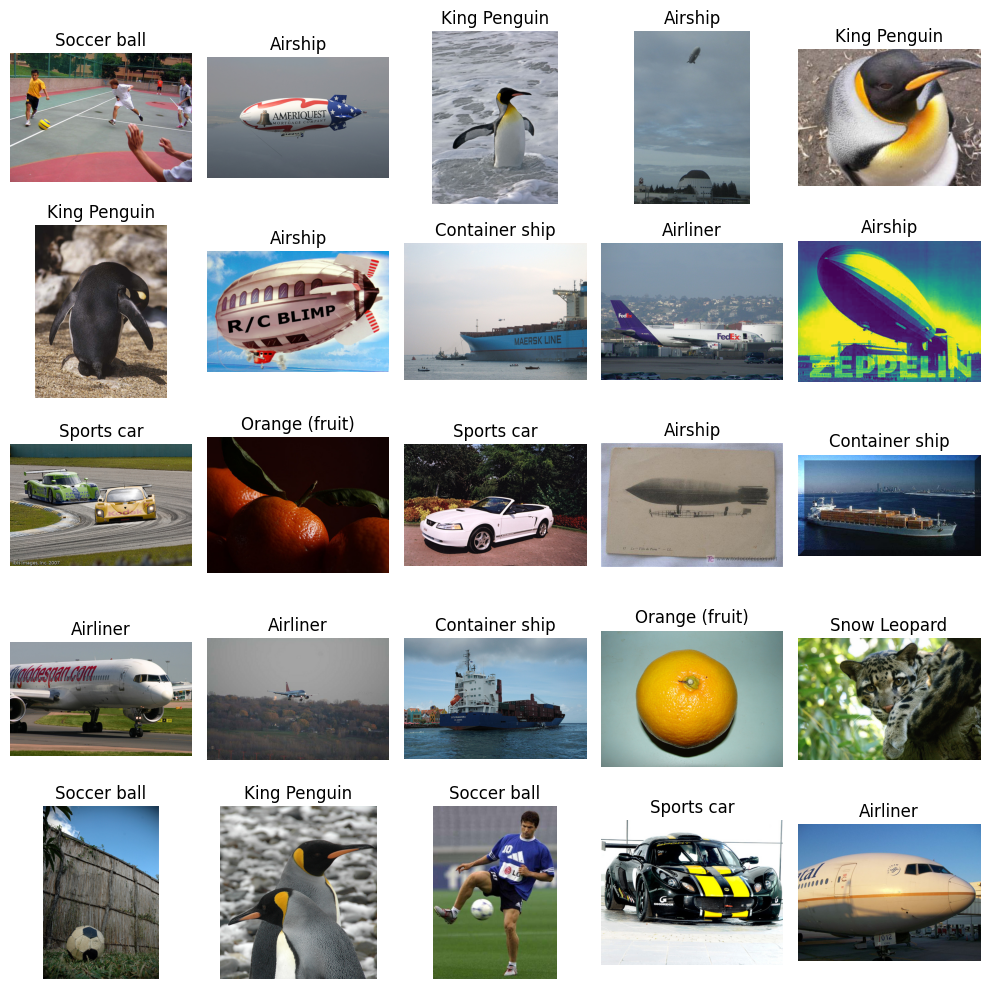

In [10]:
# Display 25 sample images from the training set
import random

# Get all image file paths and their corresponding class labels
train_image_paths = []
train_image_labels = []
for class_name in sorted(os.listdir(train_dir)):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        for fname in os.listdir(class_path):
            if fname.endswith('.JPEG'):
                train_image_paths.append(os.path.join(class_path, fname))
                train_image_labels.append(class_name)

# Randomly select 25 images
sample_indices = random.sample(range(len(train_image_paths)), 25)

fig, axs = plt.subplots(5, 5, figsize=(10, 10))
axs = axs.flatten()
for i, idx in enumerate(sample_indices):
    img = Image.open(train_image_paths[idx])
    axs[i].imshow(img)
    axs[i].set_title(train_image_labels[idx])
    axs[i].axis('off')

fig.tight_layout()
plt.show()

Let's check now the image sizes of the dataset.

In [11]:
image_shapes = []

for root, dirs, files in os.walk(train_dir):
    for file in files:
        if file.endswith('.JPEG'):
            img_path = os.path.join(root, file)
            try:
                with Image.open(img_path) as img:
                    image_shapes.append(img.size)  # (width, height)
            except:
                print("Could not open:", img_path)

# Count how often each shape appears
shape_counts = Counter(image_shapes)

print("Most common image shapes (width x height):")
for shape, count in shape_counts.most_common(10):
    print(f"{shape[0]}x{shape[1]}: {count} images")

# Optional: min and max sizes
widths, heights = zip(*image_shapes)
print("\nWidth range:", min(widths), "to", max(widths))
print("Height range:", min(heights), "to", max(heights))

Most common image shapes (width x height):
500x375: 2528 images
500x333: 1309 images
375x500: 462 images
500x334: 326 images
333x500: 254 images
500x332: 251 images
500x500: 90 images
500x335: 90 images
640x480: 72 images
500x374: 72 images

Width range: 62 to 4992
Height range: 50 to 3328


As we can see we have a variaty of image shapes going from lowest width from `62` to `4992` and height from `50` to `3328`. We will need to be aware of these shapes, cause most CNNs require fixed-size inputs. We will tackle the resizing later but lastly we will check the distribution of RGB channels.

In [12]:
train_dir = os.path.join(project_root, "data", "split_data", "train")

# Accumulators
channel_sum = np.zeros(3)
channel_squared_sum = np.zeros(3)
num_pixels = 0

for class_name in tqdm(sorted(os.listdir(train_dir)), desc="Processing"):
    class_path = os.path.join(train_dir, class_name)
    image_files = [f for f in os.listdir(class_path) if f.endswith('.JPEG')]

    for file in image_files:
        img_path = os.path.join(class_path, file)
        with Image.open(img_path) as img:
            img = img.convert("RGB")
            img_array = np.array(img) / 255.0  # Normalize to [0,1]

            # Reshape to (-1, 3) so each row is a pixel
            pixels = img_array.reshape(-1, 3)

            channel_sum += pixels.sum(axis=0)
            channel_squared_sum += (pixels ** 2).sum(axis=0)
            num_pixels += pixels.shape[0]

# Mean and std
channel_mean = channel_sum / num_pixels
channel_std = np.sqrt(channel_squared_sum / num_pixels - channel_mean ** 2)

print("RGB Channel Means :", channel_mean)
print("RGB Channel Stds  :", channel_std)

Processing: 100%|██████████| 10/10 [00:57<00:00,  5.76s/it]

RGB Channel Means : [0.48618012 0.47722418 0.45128954]
RGB Channel Stds  : [0.27312508 0.26390328 0.29191818]


We will need these RGB Channel Means and Standard Deviations later to normalize the dataset to ensure that the color channels values are standardized across the dataset.

Processing: 100%|██████████| 10/10 [00:27<00:00,  2.72s/it]


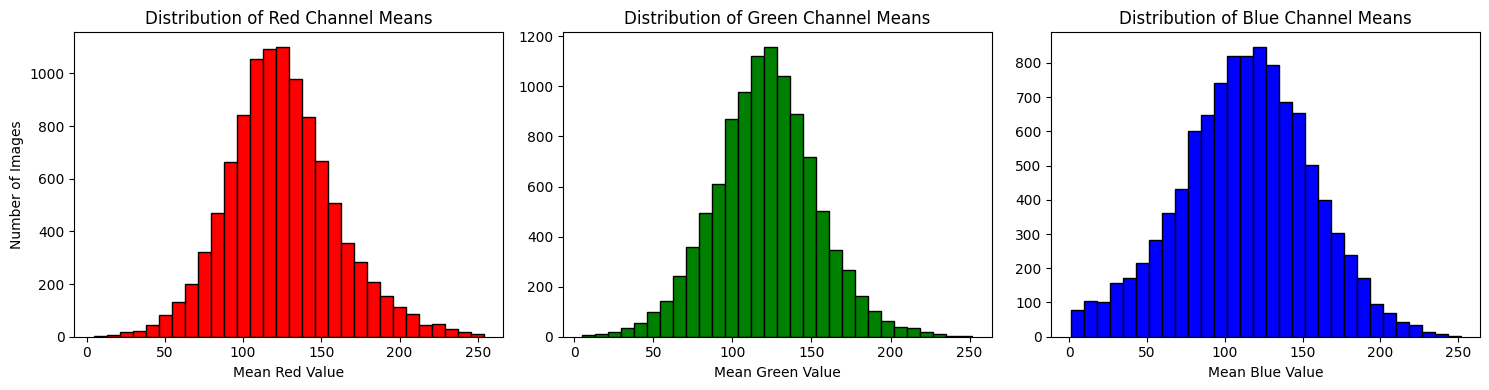

In [13]:
train_dir = os.path.join(project_root, "data", "split_data", "train")

red_means = []
green_means = []
blue_means = []

for class_name in tqdm(sorted(os.listdir(train_dir)), desc="Processing"):
    class_path = os.path.join(train_dir, class_name)
    image_files = [f for f in os.listdir(class_path) if f.endswith('.JPEG')]

    for file in image_files:
        img_path = os.path.join(class_path, file)
        with Image.open(img_path) as img:
            img = img.convert("RGB")
            img_array = np.array(img)

            red_means.append(np.mean(img_array[:, :, 0]))
            green_means.append(np.mean(img_array[:, :, 1]))
            blue_means.append(np.mean(img_array[:, :, 2]))

# Plotting
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.hist(red_means, bins=30, color='red', edgecolor='black')
plt.title("Distribution of Red Channel Means")
plt.xlabel("Mean Red Value")
plt.ylabel("Number of Images")

plt.subplot(1, 3, 2)
plt.hist(green_means, bins=30, color='green', edgecolor='black')
plt.title("Distribution of Green Channel Means")
plt.xlabel("Mean Green Value")

plt.subplot(1, 3, 3)
plt.hist(blue_means, bins=30, color='blue', edgecolor='black')
plt.title("Distribution of Blue Channel Means")
plt.xlabel("Mean Blue Value")

plt.tight_layout()
plt.show()

---

## Image resizing test

### Why These Image Transformations?

To train a deep learning model, all input images must have the same size. This script:

- Loads and displays original images.
- Compares two resizing strategies:
  - `Resize((224, 224))`: Stretches images, may distort aspect ratio.
  - `Resize(224) + CenterCrop(224)`: Keeps aspect ratio, crops center.
- Visualizes effects to help choose the best preprocessing.
- Prepares a `DataLoader` with the selected transform for model training.

Ensures consistent, model-ready input without unexpected distortions.

In [14]:
image_size = 224
custom_mean = channel_mean
custom_std = channel_std

# 1. Standard Resize (stretches)
resize_base = transforms.Resize((image_size, image_size))

# 2. Proportional Resize + CenterCrop
center_crop_base = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size)
])

In [15]:
train_transforms_resize = transforms.Compose([
    resize_base,
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=custom_mean, std=custom_std)
])

train_transforms_center_crop = transforms.Compose([
    center_crop_base,
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=custom_mean, std=custom_std)
])

# VAL/TEST TRANSFORMS
val_test_transforms_resize = transforms.Compose([
    resize_base,
    transforms.ToTensor(),
    transforms.Normalize(mean=custom_mean, std=custom_std)
])

val_test_transforms_center_crop = transforms.Compose([
    center_crop_base,
    transforms.ToTensor(),
    transforms.Normalize(mean=custom_mean, std=custom_std)
])

In [16]:
# Resize-based datasets
train_dataset_resize = ImageFolder(root=train_dir, transform=train_transforms_resize)
val_dataset_resize = ImageFolder(root=val_dir, transform=val_test_transforms_resize)
test_dataset_resize = ImageFolder(root=test_dir, transform=val_test_transforms_resize)

# Center-crop-based datasets
train_dataset_center_crop = ImageFolder(root=train_dir, transform=train_transforms_center_crop)
val_dataset_center_crop = ImageFolder(root=val_dir, transform=val_test_transforms_center_crop)
test_dataset_center_crop = ImageFolder(root=test_dir, transform=val_test_transforms_center_crop)

print(f"Resize-based Train: {len(train_dataset_resize)}, Val: {len(val_dataset_resize)}, Test: {len(test_dataset_resize)}")
print(f"Center-crop-based Train: {len(train_dataset_center_crop)}, Val: {len(val_dataset_center_crop)}, Test: {len(test_dataset_center_crop)}")

Resize-based Train: 10400, Val: 1300, Test: 1300
Center-crop-based Train: 10400, Val: 1300, Test: 1300


In [17]:
batch_size = 64
num_workers = 4

# Resize-based loaders
train_loader_resize = DataLoader(train_dataset_resize, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader_resize = DataLoader(val_dataset_resize, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader_resize = DataLoader(test_dataset_resize, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# Center-crop-based loaders
train_loader_center_crop = DataLoader(train_dataset_center_crop, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader_center_crop = DataLoader(val_dataset_center_crop, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader_center_crop = DataLoader(test_dataset_center_crop, batch_size=batch_size, shuffle=False, num_workers=num_workers)

## Baseline model for resizing test

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Baseline CNN Modell

In [20]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        # Eingangsgröße nach 3x Pooling bei 224x224 Input: 28x28
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc_layers(x)
        return x

### Modellinitialisierung, Loss, Optimizer

In [21]:
num_classes_resize = len(train_dataset_resize.classes)
num_classes_center_crop = len(train_dataset_center_crop.classes)

model_resize = SimpleCNN(num_classes=num_classes_resize).to(device)
model_center_crop = SimpleCNN(num_classes=num_classes_center_crop).to(device)

criterion_resize = nn.CrossEntropyLoss()
optimizer_resize = optim.SGD(model_resize.parameters(), lr=0.01)

criterion_center_crop = nn.CrossEntropyLoss()
optimizer_center_crop = optim.SGD(model_center_crop.parameters(), lr=0.01)

In [22]:
from src.utils import get_number_of_parameters

print(f"Number of parameters (Resize): {get_number_of_parameters(model_resize)}")
print(f"Number of parameters (Center Crop): {get_number_of_parameters(model_center_crop)}")

Number of parameters (Resize): 12939722
Number of parameters (Center Crop): 12939722


### W&B initializing

In [23]:
import wandb

# W&B logging for both models in project "del"
wandb_resize = wandb.init(
    project="del",
    name="SimpleCNN_resize",
    config={
        "architecture": "SimpleCNN",
        "epochs": 20,
        "batch_size": 32,
        "optimizer": "SGD",
        "learning_rate": 0.01,
        "loss": "CrossEntropyLoss",
        "dataset": "custom_split_data_resize",
        "image_size": 224,
        "preprocessing": "resize"
    },
    reinit=True
)

wandb_center_crop = wandb.init(
    project="del",
    name="SimpleCNN_center_crop",
    config={
        "architecture": "SimpleCNN",
        "epochs": 20,
        "batch_size": 32,
        "optimizer": "SGD",
        "learning_rate": 0.01,
        "loss": "CrossEntropyLoss",
        "dataset": "custom_split_data_center_crop",
        "image_size": 224,
        "preprocessing": "center_crop"
    },
    reinit=True
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


wandb: Currently logged in as: arian-iseni (arianarian) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## One Batch test

In [24]:
# A single batch (e.g., 4 images) from the train loader for both datasets

# For train_dataset_resize
sample_loader_resize = DataLoader(train_dataset_resize, batch_size=4, shuffle=True)
sample_inputs_resize, sample_targets_resize = next(iter(sample_loader_resize))
sample_inputs_resize, sample_targets_resize = sample_inputs_resize.to(device), sample_targets_resize.to(device)
print("Resize - Shape Input:", sample_inputs_resize.shape)
print("Resize - Labels:", sample_targets_resize)

# For train_dataset_center_crop
sample_loader_center_crop = DataLoader(train_dataset_center_crop, batch_size=4, shuffle=True)
sample_inputs_center_crop, sample_targets_center_crop = next(iter(sample_loader_center_crop))
sample_inputs_center_crop, sample_targets_center_crop = sample_inputs_center_crop.to(device), sample_targets_center_crop.to(device)
print("Center Crop - Shape Input:", sample_inputs_center_crop.shape)
print("Center Crop - Labels:", sample_targets_center_crop)

Resize - Shape Input: torch.Size([4, 3, 224, 224])
Resize - Labels: tensor([3, 4, 3, 8], device='cuda:0')
Center Crop - Shape Input: torch.Size([4, 3, 224, 224])
Center Crop - Labels: tensor([7, 9, 5, 2], device='cuda:0')


In [25]:
# For resize preprocessing
model_test_resize = SimpleCNN(num_classes=num_classes_resize).to(device)
criterion_test_resize = nn.CrossEntropyLoss()
optimizer_test_resize = optim.SGD(model_test_resize.parameters(), lr=0.01)

# For center crop preprocessing
model_test_center_crop = SimpleCNN(num_classes=num_classes_center_crop).to(device)
criterion_test_center_crop = nn.CrossEntropyLoss()
optimizer_test_center_crop = optim.SGD(model_test_center_crop.parameters(), lr=0.01)

In [26]:
num_epochs = 20
loss_history_resize = []
loss_history_center_crop = []

for epoch in range(num_epochs):
    # Train on resize batch
    model_test_resize.train()
    optimizer_test_resize.zero_grad()
    outputs_resize = model_test_resize(sample_inputs_resize)
    loss_resize = criterion_test_resize(outputs_resize, sample_targets_resize)
    loss_resize.backward()
    optimizer_test_resize.step()

    _, predicted_resize = outputs_resize.max(1)
    correct_resize = predicted_resize.eq(sample_targets_resize).sum().item()
    acc_resize = correct_resize / sample_targets_resize.size(0)
    loss_history_resize.append(loss_resize.item())

    # Train on center crop batch
    model_test_center_crop.train()
    optimizer_test_center_crop.zero_grad()
    outputs_center_crop = model_test_center_crop(sample_inputs_center_crop)
    loss_center_crop = criterion_test_center_crop(outputs_center_crop, sample_targets_center_crop)
    loss_center_crop.backward()
    optimizer_test_center_crop.step()

    _, predicted_center_crop = outputs_center_crop.max(1)
    correct_center_crop = predicted_center_crop.eq(sample_targets_center_crop).sum().item()
    acc_center_crop = correct_center_crop / sample_targets_center_crop.size(0)
    loss_history_center_crop.append(loss_center_crop.item())

    print(f"Epoch {epoch+1} | Resize Loss: {loss_resize.item():.4f} | Resize Acc: {acc_resize:.4f} | Center Crop Loss: {loss_center_crop.item():.4f} | Center Crop Acc: {acc_center_crop:.4f}")

Epoch 1 | Resize Loss: 2.3510 | Resize Acc: 0.0000 | Center Crop Loss: 2.2876 | Center Crop Acc: 0.0000
Epoch 2 | Resize Loss: 2.1749 | Resize Acc: 1.0000 | Center Crop Loss: 2.0605 | Center Crop Acc: 0.5000
Epoch 3 | Resize Loss: 1.9692 | Resize Acc: 0.7500 | Center Crop Loss: 1.8460 | Center Crop Acc: 0.5000
Epoch 4 | Resize Loss: 1.7302 | Resize Acc: 0.7500 | Center Crop Loss: 1.6345 | Center Crop Acc: 0.7500
Epoch 5 | Resize Loss: 1.4523 | Resize Acc: 0.7500 | Center Crop Loss: 1.4223 | Center Crop Acc: 0.7500
Epoch 6 | Resize Loss: 1.1447 | Resize Acc: 0.7500 | Center Crop Loss: 1.2118 | Center Crop Acc: 0.7500
Epoch 7 | Resize Loss: 0.8615 | Resize Acc: 0.7500 | Center Crop Loss: 1.0144 | Center Crop Acc: 0.7500
Epoch 8 | Resize Loss: 0.6416 | Resize Acc: 1.0000 | Center Crop Loss: 0.8313 | Center Crop Acc: 1.0000
Epoch 9 | Resize Loss: 0.4733 | Resize Acc: 1.0000 | Center Crop Loss: 0.6680 | Center Crop Acc: 1.0000
Epoch 10 | Resize Loss: 0.3432 | Resize Acc: 1.0000 | Center Cro

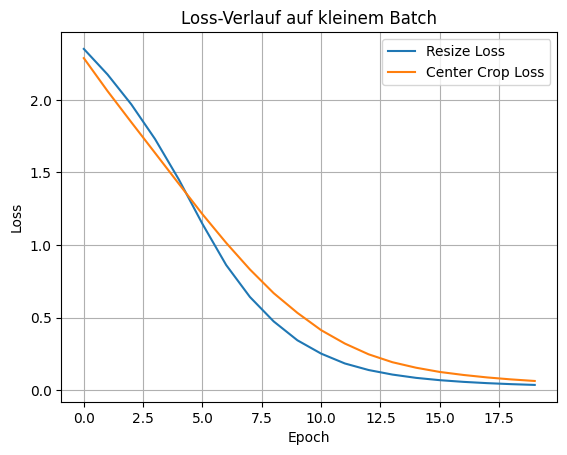

In [27]:
import matplotlib.pyplot as plt

plt.plot(loss_history_resize, label="Resize Loss")
plt.plot(loss_history_center_crop, label="Center Crop Loss")
plt.title("Loss-Verlauf auf kleinem Batch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

### One-Batch test

Resize reducses the loss faster then Center crop. Both methods converge, but Resize has consistently lower loss.

### Trainingsloop

In [28]:
def train(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

### Validierungsloop

In [29]:
def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    return running_loss / total, correct / total

### Training

In [30]:
from tqdm.notebook import trange
import os
import pickle
import hashlib

def get_model_hash(model, config):
    # Serialize model architecture and config for hashing
    model_str = str(model)
    config_str = str(config)
    hash_input = (model_str + config_str).encode('utf-8')
    return hashlib.md5(hash_input).hexdigest()

# Directory to store cached results
cache_dir = project_root + "/training_cache"
os.makedirs(cache_dir, exist_ok=True)

# ---  resize model ---
model_test_resize = SimpleCNN(num_classes=num_classes_resize).to(device)
criterion_test_resize = nn.CrossEntropyLoss()
optimizer_test_resize = optim.SGD(model_test_resize.parameters(), lr=0.01)

model_hash_resize = get_model_hash(model_test_resize, wandb.config)
cache_path_resize = os.path.join(cache_dir, f"{model_hash_resize}_resize.pkl")

if os.path.exists(cache_path_resize):
    with open(cache_path_resize, "rb") as f:
        cached = pickle.load(f)
    train_losses_resize = cached["train_losses"]
    val_losses_resize = cached["val_losses"]
    train_accs_resize = cached["train_accs"]
    val_accs_resize = cached["val_accs"]
    print("Loaded cached training results for resize model/config.")
    for epoch, (train_loss, train_acc, val_loss, val_acc) in enumerate(zip(train_losses_resize, train_accs_resize, val_losses_resize, val_accs_resize)):
        wandb.log({
            "epoch_resize": epoch + 1,
            "train_loss_resize": train_loss,
            "train_acc_resize": train_acc,
            "val_loss_resize": val_loss,
            "val_acc_resize": val_acc
        })
else:
    num_epochs_resize = wandb.config.epochs
    train_losses_resize, val_losses_resize = [], []
    train_accs_resize, val_accs_resize = [], []

    for epoch in trange(num_epochs_resize, desc="Epochs (resize)"):
        train_loss, train_acc = train(model_test_resize, train_loader_resize, optimizer_test_resize, criterion_test_resize)
        val_loss, val_acc = evaluate(model_test_resize, val_loader_resize, criterion_test_resize)

        train_losses_resize.append(train_loss)
        val_losses_resize.append(val_loss)
        train_accs_resize.append(train_acc)
        val_accs_resize.append(val_acc)

        print(f"[Resize] Epoch {epoch+1}/{num_epochs_resize} "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

        wandb.log({
            "epoch_resize": epoch + 1,
            "train_loss_resize": train_loss,
            "train_acc_resize": train_acc,
            "val_loss_resize": val_loss,
            "val_acc_resize": val_acc
        })
    with open(cache_path_resize, "wb") as f:
        pickle.dump({
            "train_losses": train_losses_resize,
            "val_losses": val_losses_resize,
            "train_accs": train_accs_resize,
            "val_accs": val_accs_resize
        }, f)

# --- center crop model ---
model_test_center_crop = SimpleCNN(num_classes=num_classes_center_crop).to(device)
criterion_test_center_crop = nn.CrossEntropyLoss()
optimizer_test_center_crop = optim.SGD(model_test_center_crop.parameters(), lr=0.01)

model_hash_center_crop = get_model_hash(model_test_center_crop, wandb.config)
cache_path_center_crop = os.path.join(cache_dir, f"{model_hash_center_crop}_centercrop.pkl")

if os.path.exists(cache_path_center_crop):
    with open(cache_path_center_crop, "rb") as f:
        cached = pickle.load(f)
    train_losses_center_crop = cached["train_losses"]
    val_losses_center_crop = cached["val_losses"]
    train_accs_center_crop = cached["train_accs"]
    val_accs_center_crop = cached["val_accs"]
    print("Loaded cached training results for center crop model/config.")
    for epoch, (train_loss, train_acc, val_loss, val_acc) in enumerate(zip(train_losses_center_crop, train_accs_center_crop, val_losses_center_crop, val_accs_center_crop)):
        wandb.log({
            "epoch_center_crop": epoch + 1,
            "train_loss_center_crop": train_loss,
            "train_acc_center_crop": train_acc,
            "val_loss_center_crop": val_loss,
            "val_acc_center_crop": val_acc
        })
else:
    num_epochs_center_crop = wandb.config.epochs
    train_losses_center_crop, val_losses_center_crop = [], []
    train_accs_center_crop, val_accs_center_crop = [], []

    for epoch in trange(num_epochs_center_crop, desc="Epochs (center crop)"):
        train_loss, train_acc = train(model_test_center_crop, train_loader_center_crop, optimizer_test_center_crop, criterion_test_center_crop)
        val_loss, val_acc = evaluate(model_test_center_crop, val_loader_center_crop, criterion_test_center_crop)

        train_losses_center_crop.append(train_loss)
        val_losses_center_crop.append(val_loss)
        train_accs_center_crop.append(train_acc)
        val_accs_center_crop.append(val_acc)

        print(f"[Center Crop] Epoch {epoch+1}/{num_epochs_center_crop} "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

        wandb.log({
            "epoch_center_crop": epoch + 1,
            "train_loss_center_crop": train_loss,
            "train_acc_center_crop": train_acc,
            "val_loss_center_crop": val_loss,
            "val_acc_center_crop": val_acc
        })
    with open(cache_path_center_crop, "wb") as f:
        pickle.dump({
            "train_losses": train_losses_center_crop,
            "val_losses": val_losses_center_crop,
            "train_accs": train_accs_center_crop,
            "val_accs": val_accs_center_crop
        }, f)

Loaded cached training results for resize model/config.
Loaded cached training results for center crop model/config.


### Test-Set evaluation and logging

In [31]:
# Evaluate and log for resize model
test_loss_resize, test_acc_resize = evaluate(model_test_resize, test_loader_resize, criterion_test_resize)
print(f"[Resize] Test Loss: {test_loss_resize:.4f}, Test Accuracy: {test_acc_resize:.4f}")

wandb.log({
    "test_loss_resize": test_loss_resize,
    "test_acc_resize": test_acc_resize
})

# Evaluate and log for center crop model
test_loss_center_crop, test_acc_center_crop = evaluate(model_test_center_crop, test_loader_center_crop, criterion_test_center_crop)
print(f"[Center Crop] Test Loss: {test_loss_center_crop:.4f}, Test Accuracy: {test_acc_center_crop:.4f}")

wandb.log({
    "test_loss_center_crop": test_loss_center_crop,
    "test_acc_center_crop": test_acc_center_crop
})

wandb.finish()

[Resize] Test Loss: 2.3065, Test Accuracy: 0.1023
[Center Crop] Test Loss: 2.3035, Test Accuracy: 0.1000


epoch_center_crop,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch_resize,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_acc_center_crop,▁
test_acc_resize,▁
test_loss_center_crop,▁
test_loss_resize,▁
train_acc_center_crop,▁▃▄▄▅▅▅▆▆▆▆▇▇▇▇▇████
train_acc_resize,▁▃▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss_center_crop,█▆▆▅▅▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁
train_loss_resize,█▆▅▅▄▄▄▄▃▃▃▂▂▂▂▂▂▁▁▁
val_acc_center_crop,▁▁▂▃▄▄▆▆▆▆▄▆▇▇▇▇████


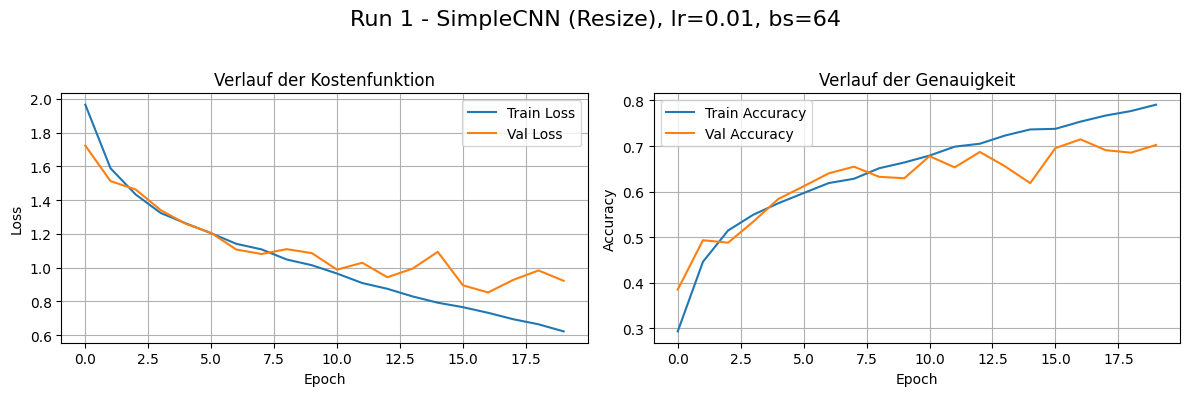

In [32]:
plot_training_curves(train_losses_resize, val_losses_resize, train_accs_resize, val_accs_resize, run_number=1, model_name="SimpleCNN (Resize)", learning_rate=0.01, batch_size=64)

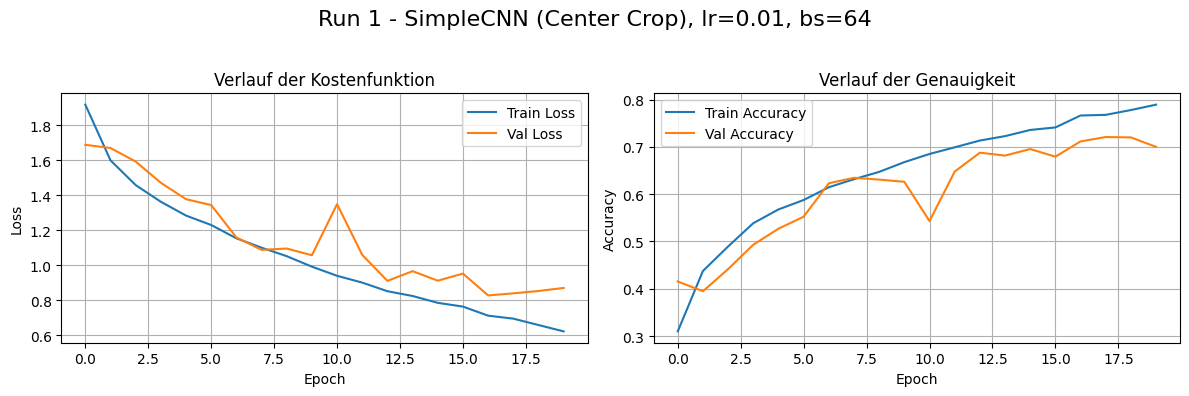

In [33]:

plot_training_curves(train_losses_center_crop, val_losses_center_crop, train_accs_center_crop, val_accs_center_crop, run_number=1, model_name="SimpleCNN (Center Crop)", learning_rate=0.01, batch_size=64)

## Train overview

**CNN with resize method** 
- Val accuracy increases steadily and reaches about 0.72 towards the end
- Train accuracy increases continuously without strong overfitting
- Validation loss remains relatively stable after Epoch 10 and decreases slightly

**CNN with center crop method**
- Val Accuracy is similar, but somewhat more inconsistent - more fluctuations.
- When looking at Validation Accuracy and Validation Loss at the same time, the training appears somewhat more unstable.
- Train Accuracy is almost identical, but the validation result is not quite as constant as with Resize.

### Test results

**Resize: Test accuracy = 8.69%**

**Center Crop: Test accuracy = 9.92%**

Both models have a very low test accuracy (both under 10%) which indicates that the models aren't trained well, but that will be problem for later. For now we will use the `center_crop` method for the future tweaking of the model because of these results:

- **Image distortion:** The simple resize method (stretching) distorts the images, which can lead to unnatural proportions. This can be particularly problematic if your original images have very different aspect ratios (e.g. 500x375 vs 375x500).

- **Loss of information:** Center Crop retains the original proportions of the images and only cuts off the edges. This is often better than distorting the entire image.

- **Consistency:** Center Crop creates more consistent image sections because it always uses the central part of the image, which often contains the most important visual information.

We will also check with Crossvalidation those claims in the next section.

### Crossfold validation

In [34]:
def _make_cv_cache_name(model_class, dataset, num_classes, k, epochs, batch_size, lr):
    """
    Create a unique cache filename for cross-validation results, using as much dataset-specific
    information as possible. This version hashes the indices of the first 100 samples and the class
    distribution, so that different datasets (even with the same root) get different cache files.
    """
    # Try to get a unique identifier for the dataset
    dataset_id_parts = []

    # Use root path if available
    if hasattr(dataset, 'root'):
        dataset_id_parts.append(str(dataset.root))
    # Use transforms if available (to distinguish resize/crop)
    if hasattr(dataset, 'transform') and dataset.transform is not None:
        dataset_id_parts.append(str(dataset.transform))
    # Use class names if available
    if hasattr(dataset, 'classes'):
        dataset_id_parts.append(str(dataset.classes))
    # Use targets if available (for class distribution)
    if hasattr(dataset, 'targets'):
        targets = dataset.targets
        if isinstance(targets, list):
            targets_arr = np.array(targets)
        else:
            targets_arr = np.array(targets)
        class_hist = np.bincount(targets_arr) if len(targets_arr) > 0 else []
        dataset_id_parts.append("hist" + str(class_hist.tolist()))
        # Hash the first 100 indices to distinguish different splits
        first_100 = targets_arr[:100]
        dataset_id_parts.append("first100_" + hashlib.md5(first_100.tobytes()).hexdigest())
    else:
        # Fallback: use length
        dataset_id_parts.append("len" + str(len(dataset)))

    dataset_id = "_".join(dataset_id_parts)

    # Model class name
    model_name = model_class.__name__
    # Compose a string with all params
    cache_str = f"{model_name}_{dataset_id}_nc{num_classes}_k{k}_ep{epochs}_bs{batch_size}_lr{lr}"
    # Hash to avoid long filenames
    cache_hash = hashlib.md5(cache_str.encode()).hexdigest()
    cache_dir = "./cv_cache"
    os.makedirs(cache_dir, exist_ok=True)
    cache_path = os.path.join(cache_dir, f"cv_{cache_hash}.pkl")
    return cache_path

def cross_validate_model(model_class, dataset, num_classes, k=5, epochs=5, batch_size=32, lr=0.01):
    cache_path = _make_cv_cache_name(model_class, dataset, num_classes, k, epochs, batch_size, lr)
    if os.path.exists(cache_path):
        print(f"Loading cached cross-validation results from {cache_path}")
        with open(cache_path, "rb") as f:
            fold_results, mean_acc, std_acc = pickle.load(f)
        print(f"\n Durchschnittliche Accuracy: {mean_acc:.4f}")
        print(f"Standardabweichung (statistischer Fehler): {std_acc:.4f}")
        return fold_results, mean_acc, std_acc

    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    targets = [label for _, label in dataset]

    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(targets)), targets)):
        print(f"\n Fold {fold+1}/{k}")

        # Teilmengen erzeugen
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

        # Neues Modell pro Fold
        model = model_class(num_classes=num_classes).to(device)
        optimizer = optim.SGD(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        # Training & Evaluation
        for epoch in range(epochs):
            train_loss, train_acc = train(model, train_loader, optimizer, criterion)
            val_loss, val_acc = evaluate(model, val_loader, criterion)
            print(f"  Epoch {epoch+1}/{epochs}: Val Acc = {val_acc:.4f}")

        # Ergebnis für diesen Fold speichern
        fold_results.append(val_acc)

    # Statistischer Fehler (Mittelwert und Standardabweichung)
    mean_acc = np.mean(fold_results)
    std_acc = np.std(fold_results)

    print(f"\n Durchschnittliche Accuracy: {mean_acc:.4f}")
    print(f"Standardabweichung (statistischer Fehler): {std_acc:.4f}")

    # Save to cache
    with open(cache_path, "wb") as f:
        pickle.dump((fold_results, mean_acc, std_acc), f)

    return fold_results, mean_acc, std_acc

In [35]:
#5-fold CV mit 3 Epochen pro Fold für das Resize-Dataset
folds, mean_acc, std_acc = cross_validate_model(
    model_class=SimpleCNN,
    dataset=train_dataset_resize,
    num_classes=len(train_dataset_resize.classes),
    k=5,
    epochs=3,
    batch_size=32,
    lr=0.01
)

Loading cached cross-validation results from ./cv_cache/cv_f09cec1b44bb7456a5448a16b5a3ed88.pkl

 Durchschnittliche Accuracy: 0.5522
Standardabweichung (statistischer Fehler): 0.0070


In [36]:
# 5-fold CV mit 3 Epochen pro Fold für das Crop-Dataset
folds, mean_acc, std_acc = cross_validate_model(
    model_class=SimpleCNN,
    dataset=train_dataset_center_crop,
    num_classes=len(train_dataset_center_crop.classes),
    k=5,
    epochs=3,
    batch_size=32,
    lr=0.01
)

Loading cached cross-validation results from ./cv_cache/cv_164b6f61a7268f465d42971f33752742.pkl

 Durchschnittliche Accuracy: 0.5426
Standardabweichung (statistischer Fehler): 0.0122


---

## CrossValidation 5-Fold with 3 Epoch overview

**Average performance:**
- Resize: 55.22% ± 0.70%
- Center Crop: 54.26% ± 1.22%

**Important observations:**
- Resize shows a slightly better average Accuracy (0.96% higher)
- Resize has a significantly smaller standard deviation (0.70% vs 1.22%)
- The smaller standard deviation for Resize indicates more stable and consistent results 
- Both methods show a clear improvement across epochs

**Analysis of stability:**
- The standard deviation for Resize (0.70%) is about 1.7x smaller than for Center Crop (1.22%)
- This means that Resize is significantly more robust and less dependent on the specific split of the data
- The more consistent performance across different folds is an important indicator of the reliability of the method

The cross-validation results show that Resize performs better than Center Crop in terms of both average accuracy and stability. Therefore, I will continue with the `resize` method for **ALL** future tests and tweaks.

---

# Setup for experimentation

To thoroughly assess the model's performance, I'll compute accuracy metrics on both training and test sets. This dual evaluation approach allows us to understand how well the model generalizes to new data versus its performance on familiar examples. Additionally, I'll monitor the training loss to observe the model's learning progress and convergence patterns.

To maintain experimental consistency, I'll initialize fixed random seeds across Python, NumPy, and PyTorch. This standardization ensures that our experimental results remain reproducible across multiple runs, eliminating the influence of random variations in the outcomes.

In [37]:
def set_seed(seed=2277):
    random.seed(seed)
    np.random.seed(seed)
    
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

## Trainer

To facilitate systematic experimentation with various model configurations, learning parameters, and optimization strategies, I'll implement a dedicated `Trainer` class. This class will serve as a comprehensive training framework, handling model initialization, optimizer setup, and loss function configuration. It will manage the complete training lifecycle, including both training and validation phases. Furthermore, the `Trainer` will integrate with Weights & Biases to automatically track and visualize performance metrics, enabling detailed analysis of the model's behavior throughout the training process.

In [72]:
class Trainer:
    def __init__(self,
                 model,
                 experiment_name,
                 train_loader,
                 val_loader,
                 test_loader,
                 cache_dir="cache",
                 device=None,
                 wandb_project="del-main-mc",
                 wandb_config=None,
                 criterion=None,
                 optimizer=None,
                 learning_rate=0.01,
                 epochs=40,
                 num_classes=None):
        
        set_seed()
        
        self.model = model
        self.experiment_name = experiment_name
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.cache_dir = cache_dir

        # Prefer CUDA if available, else CPU
        self.device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.wandb_project = wandb_project
        self.wandb_config = wandb_config or {}
        self.epochs = epochs
        self.num_classes = num_classes or len(train_loader.dataset.classes)
        
        # Initialize model components
        self.model = self.model.to(self.device)
        self.criterion = criterion or nn.CrossEntropyLoss()
        self.optimizer = optimizer or optim.SGD(self.model.parameters(), lr=learning_rate)
        
        # Create cache directory if it doesn't exist
        os.makedirs(cache_dir, exist_ok=True)
        
        # Initialize metrics
        self.accuracy = Accuracy(task='multiclass', num_classes=self.num_classes).to(self.device)
        
        # Initialize metrics storage
        self.fold_metrics = {
            'train_loss': None,
            'train_acc': None,
            'val_loss': None,
            'val_acc': None,
            'test_loss': None,
            'test_acc': None
        }
        
    def _get_model_hash(self):
        """Generate a unique hash for the model configuration and experiment."""
        model_str = str(self.model)
        config_str = f"{model_str}|{self.experiment_name}|{self.epochs}|{self.optimizer}|{self.criterion}|{self.num_classes}"
        return hashlib.md5(config_str.encode('utf-8')).hexdigest()
    
    def _prepare_wandb_config(self):
        """Prepare the wandb configuration"""
        base_config = {
            "architecture": self.model.__class__.__name__,
            "epochs": self.epochs,
            "batch_size": self.train_loader.batch_size,
            "optimizer": type(self.optimizer).__name__,
            "learning_rate": self.optimizer.param_groups[0]['lr'],
            "loss": type(self.criterion).__name__,
            "num_classes": self.num_classes,
            "device": str(self.device)
        }
        return {**base_config, **self.wandb_config}
    
    def train_epoch(self):
        """Train for one epoch and compute metrics on final weights."""
        self.model.train()
        running_loss = 0.0
        self.accuracy.reset()
        
        for inputs, targets in tqdm(self.train_loader, desc="Training"):  # batch loop
            inputs, targets = inputs.to(self.device), targets.to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, targets)
            loss.backward()
            self.optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            self.accuracy.update(outputs, targets)
        
        epoch_loss = running_loss / len(self.train_loader.dataset)
        epoch_acc = self.accuracy.compute().item()
        return epoch_loss, epoch_acc
    
    def evaluate(self, loader):
        """Evaluate the model on a given loader."""
        self.model.eval()
        running_loss = 0.0
        self.accuracy.reset()
        
        with torch.no_grad():
            for inputs, targets in tqdm(loader, desc="Evaluating"):  # batch loop
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                
                running_loss += loss.item() * inputs.size(0)
                self.accuracy.update(outputs, targets)
        
        epoch_loss = running_loss / len(loader.dataset)
        epoch_acc = self.accuracy.compute().item()
        return epoch_loss, epoch_acc
    
    def run(self):
        """Run the training and evaluation process, with caching."""
        model_hash = self._get_model_hash()
        cache_path = os.path.join(self.cache_dir, f"{model_hash}_{self.experiment_name}.pkl")

        if os.path.exists(cache_path):
            print(f"Loading cached results for {self.experiment_name} from {cache_path}")
            with open(cache_path, "rb") as f:
                cached = pickle.load(f)
            # Do NOT log to wandb if loading from cache
            print(f"Test Loss: {cached['test_loss']:.4f}, Test Accuracy: {cached['test_acc']:.4f}")
            self.fold_metrics.update({
                'train_loss': cached['train_losses'][-1],
                'train_acc': cached['train_accs'][-1],
                'val_loss': cached['val_losses'][-1],
                'val_acc': cached['val_accs'][-1],
                'test_loss': cached['test_loss'],
                'test_acc': cached['test_acc']
            })
            return

        # Fresh run
        wandb.init(
            project=self.wandb_project,
            name=self.experiment_name,
            config=self._prepare_wandb_config(),
            reinit=True
        )
        train_losses, val_losses = [], []
        train_accs, val_accs = [], []
        
        for epoch in range(self.epochs):
            train_loss, train_acc = self.train_epoch()
            val_loss, val_acc = self.evaluate(self.val_loader)
            
            train_losses.append(train_loss)
            train_accs.append(train_acc)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            
            wandb.log({
                "epoch": epoch+1,
                "train_loss": train_loss,
                "train_acc": train_acc,
                "val_loss": val_loss,
                "val_acc": val_acc
            })
            print(f"Epoch {epoch+1}/{self.epochs} \
                  Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | \
                  Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
        
        test_loss, test_acc = self.evaluate(self.test_loader)
        wandb.log({"test_loss": test_loss, "test_acc": test_acc})
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

        self.fold_metrics.update({
            'train_loss': train_losses[-1], 'train_acc': train_accs[-1],
            'val_loss': val_losses[-1],   'val_acc': val_accs[-1],
            'test_loss': test_loss,       'test_acc': test_acc
        })
        
        with open(cache_path, "wb") as f:
            pickle.dump({
                "train_losses": train_losses,
                "val_losses": val_losses,
                "train_accs": train_accs,
                "val_accs": val_accs,
                "test_loss": test_loss,
                "test_acc": test_acc
            }, f)
        
        wandb.finish()

Dataloader method to create train_loader, val_loader, test_loader.

In [39]:
def create_data_loaders(train_dataset, val_dataset, test_dataset, batch_size, num_workers=4):
    """
    Create data loaders with specified batch size.
    
    Args:
        train_dataset: Training dataset
        val_dataset: Validation dataset
        test_dataset: Test dataset
        batch_size: Batch size for all loaders
        num_workers: Number of workers for data loading
        
    Returns:
        tuple: (train_loader, val_loader, test_loader)
    """
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=num_workers
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=num_workers
    )
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=num_workers
    )
    
    return train_loader, val_loader, test_loader 

## Baseline model

In [41]:
class BaselineCNN(nn.Module):
    def __init__(self, num_classes):
        super(BaselineCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        # Eingangsgröße nach 3x Pooling bei 224x224 Input: 28x28
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc_layers(x)
        return x

## Load data

In [42]:
from torch.utils.data import Subset

# Load full datasets
full_train_dataset = ImageFolder(root=train_dir, transform=train_transforms_center_crop)
full_val_dataset = ImageFolder(root=val_dir, transform=val_test_transforms_center_crop)
full_test_dataset = ImageFolder(root=test_dir, transform=val_test_transforms_center_crop)

train_dataset = Subset(full_train_dataset, [0])
val_dataset = Subset(full_val_dataset, [0])
test_dataset = Subset(full_test_dataset, list(range(10)))

num_classes = len(full_train_dataset.classes)
model = BaselineCNN(num_classes=num_classes).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1)

## Overfit train

In [43]:

train_loader_1, val_loader_1, test_loader_1 = create_data_loaders(train_dataset, train_dataset, test_dataset, batch_size=1, num_workers=0)

overfit_trainer = Trainer(
    model=model,
    experiment_name="overfit_test",
    train_loader=train_loader_1,
    val_loader=val_loader_1,
    test_loader=test_loader_1,
    device=device,
    wandb_project="del-main-mc",
    wandb_config={"overfit_test": True},
    optimizer=optimizer,
    epochs=20,
    num_classes=num_classes
)

overfit_trainer.run()

Loading cached results for overfit_test from cache/4f86daaed43691dc42d4d1ee925e70dd_overfit_test.pkl


Test Loss: 0.0000, Test Accuracy: 1.0000


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_acc,▁
test_loss,▁
train_acc,▁███████████████████
train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
test_acc,1
test_loss,0.0
train_acc,1


In [80]:
%wandb arianarian/del-main-mc/reports/Overfit--VmlldzoxMzE3NjYyMA

### Observations

1. **Train Loss** rapidly drops to zero within a few epochs, indicating the model has perfectly memorized the training sample.
2. **Train Accuracy** reaches 1.0 after epoch 2 and remains stable, confirming successful overfitting on the single sample.
3. **Validation and Test Accuracy** both reach 1.0, likely because the same or very similar sample was used across splits.

### Interpretation

- The model is capable of learning and memorizing data, proving that the training loop and architecture work correctly.
- This confirms that the model can overfit a single sample as expected, which is a good sign for debugging and initial testing.

## Baseline after Image resizing test

- **Learning-Rate:** 0.1
- **Batch-size:** 64
- **Optimizer:** SDG
- **Weight-Initialization:** He with ReLU non-linearity
- **Epochs:** 40

These were choosen by recommendations in the web and through AI. Those default hyperparameters will be used for all future experiments.

In [45]:
train_loader_64, val_loader_64, test_loader_64 = create_data_loaders(full_train_dataset, full_val_dataset, full_test_dataset, batch_size=64, num_workers=4)

baseline_trainer = Trainer(
    model=model,
    experiment_name="baseline-train",
    train_loader=train_loader_64,
    val_loader=val_loader_64,
    test_loader=test_loader_64,
    device=device,
    wandb_project="del-main-mc",
    wandb_config={"baseline-train": True},
    optimizer=optimizer,
    epochs=40,
    num_classes=num_classes
)

baseline_trainer.run()

Loading cached results for baseline-train from cache/bc5979ff42d6bd66302500ac5f7cebd1_baseline-train.pkl


Test Loss: 1.3752, Test Accuracy: 0.7754


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_acc,▁
test_loss,▁
train_acc,▁▂▃▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇███████████████████
train_loss,█▇▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▄▄▄▅▅▇▄▆▆▆▇▇▇▇▆▇▇▇▇▇██▇███▇▇▇▇█████████
val_loss,█▅▄▄▃▃▁▅▂▂▂▂▂▁▂▂▁▁▂▄▂▂▃▅▂▃▂▃▃▄▃▃▃▅▅▃▄▄▄▄
epoch,40
test_acc,0.77538
test_loss,1.37523
train_acc,0.97567


In [46]:
%wandb arianarian/del-main-mc/reports/Baseline-after-Image-resize-test--VmlldzoxMzE2ODgzNA

### Observations

1. **Train Loss** steadily decreased from 2.02 to 0.08 over 40 epochs, showing consistent learning and convergence.
2. **Validation Accuracy** improved from ~39% to ~77%, with some fluctuations due to overfitting in later epochs.
3. **Train Accuracy** reached ~97.6%, indicating the model fits the training data very well.
4. **Validation Loss** fluctuated and increased in later epochs, a potential sign of slight overfitting.
5. **Test Accuracy** reached **~77.5%**, suggesting decent generalization performance.

### Interpretation

- The model is learning effectively: He initialization, ReLU, and SGD with lr=0.1 seem well-matched.
- Some overfitting is visible after epoch ~20 (gap between train and val metrics), but not critical—generalization is still acceptable.

## Learning rate test

In [47]:
learning_rates = [0.01, 0.001, 0.000001]

for lr in learning_rates:
    print(f"\nTraining with learning rate: {lr}")
    # Re-initialize model and optimizer for each run
    model_lr = SimpleCNN(num_classes=num_classes).to(device)
    optimizer_lr = optim.SGD(model_lr.parameters(), lr=lr)
    
    trainer_lr = Trainer(
        model=model_lr,
        experiment_name=f"lr_{lr}",
        train_loader=train_loader_64,
        val_loader=val_loader_64,
        test_loader=test_loader_64,
        device=device,
        wandb_project="del-main-mc",
        wandb_config={"learning_rate": lr},
        optimizer=optimizer_lr,
        epochs=40,
        num_classes=num_classes
    )
    
    trainer_lr.run()



Training with learning rate: 0.01
Loading cached results for lr_0.01 from cache/fb0e8d04d60b4a44db99f9d664e67811_lr_0.01.pkl


Test Loss: 1.1414, Test Accuracy: 0.6969


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_acc,▁
test_loss,▁
train_acc,▁▂▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█████████
train_loss,█▇▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_acc,▁▃▄▄▅▄▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█▇▇█▇███▇▇▇▇▇▇█▇
val_loss,█▆▅▅▅▅▄▄▃▃▃▂▂▂▃▁▂▂▂▁▂▂▁▁▁▂▂▁▂▁▁▁▂▃▃▂▂▂▂▃
epoch,40
test_acc,0.69692
test_loss,1.14142
train_acc,0.93144



Training with learning rate: 0.001
Loading cached results for lr_0.001 from cache/9c77077ea85a317d874e8161480ac686_lr_0.001.pkl


Test Loss: 1.2071, Test Accuracy: 0.6054


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_acc,▁
test_loss,▁
train_acc,▁▂▃▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████
train_loss,██▇▆▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_acc,▁▁▂▃▄▃▄▅▄▅▅▅▅▅▅▆▆▆▆▆▆▇▆▇▇▆▇▇▇▇▇▇▇▆▇▇████
val_loss,██▇▆▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▃▂▂▁▁▁▁
epoch,40
test_acc,0.60538
test_loss,1.20714
train_acc,0.62933



Training with learning rate: 1e-06
Loading cached results for lr_1e-06 from cache/0f81d57b761b0a717e7308c004110584_lr_1e-06.pkl


Test Loss: 2.2999, Test Accuracy: 0.1092


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_acc,▁
test_loss,▁
train_acc,▂▁▂▂▁▂▂▂▃▃▄▃▅▃▄▄▄▃▅▄▄▅▆▃▆▆▅▆▆▆▆▆▇█▅▇▇▇█▇
train_loss,███▇█▇▇▆▇▆▆▆▆▆▅▄▅▅▄▄▅▄▄▄▃▃▃▂▂▂▂▂▁▁▂▂▁▁▁▁
val_acc,▁▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇██
val_loss,███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁
epoch,40
test_acc,0.10923
test_loss,2.29987
train_acc,0.11913


In [48]:
%wandb arianarian/del-main-mc/reports/Learning-Rate-Test--VmlldzoxMzE2OTI4OQ

### Learning Rate Comparison for Baseline CNN

#### Observations

**Learning Rate = 0.01**
1. **Train Loss** steadily decreases from 1.92 → 0.20; Train Accuracy improves from ~30% → 93%.
2. **Validation Accuracy** rises from ~36% → ~77%, with minor fluctuations after epoch 25.
3. **Model generalizes well**, with **Test Accuracy: ~69.7%**, indicating strong learning progress.

**Learning Rate = 0.001**
1. **Train Loss** decreases much slower from 2.28 → 1.12 over 40 epochs.
2. **Train Accuracy** improves slowly (~16% → 63%); **Val Accuracy** peaks at ~60.5%.
3. Learning is happening, but **convergence is slow**, and final performance is weaker than LR=0.01.

**Learning Rate = 1e-6**
1. **Train & Val Loss** remain around 2.30; Accuracy stuck near 10–11%.
2. Indicates **no meaningful learning** – the model is essentially guessing (like random baseline).
3. Learning rate is **too small** for SGD to escape the initial plateau.

#### Interpretation

- **0.01** is the best choice among the three: it provides **good convergence** and **generalization**.
- **0.001** is stable but too slow; may need more epochs to match 0.01 performance.
- **1e-6** fails to train – the gradient steps are too tiny to update weights effectively.

## Batchsize test

In [49]:
batch_sizes = [16, 32, 64, 256, 512]

for bs in batch_sizes:
    print("--------------------------------")
    print(f"\nTraining with batch size: {bs}")
    print("--------------------------------")
    train_loader_bs, val_loader_bs, test_loader_bs = create_data_loaders(
        full_train_dataset, full_val_dataset, full_test_dataset, batch_size=bs, num_workers=4
    )

    model_bs = SimpleCNN(num_classes=num_classes).to(device)
    optimizer_bs = optim.SGD(model_bs.parameters(), lr=0.01)
    
    trainer_bs = Trainer(
        model=model_bs,
        experiment_name=f"batch_size_{bs}",
        train_loader=train_loader_bs,
        val_loader=val_loader_bs,
        test_loader=test_loader_bs,
        device=device,
        wandb_project="del-main-mc",
        wandb_config={"batch_size": bs},
        optimizer=optimizer_bs,
        epochs=40,
        num_classes=num_classes
    )
    trainer_bs.run()

--------------------------------

Training with batch size: 16
--------------------------------
Loading cached results for batch_size_16 from cache/0ff4cbf443afd5a4aa20fd7efe19eceb_batch_size_16.pkl


Test Loss: 1.1163, Test Accuracy: 0.7938


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_acc,▁
test_loss,▁
train_acc,▁▃▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█████████████████
train_loss,█▆▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▃▃▃▅▆▆▆▆▇▇▆▇█▇▇█▇██▇█████████▇█▇███████
val_loss,█▆▅▅▃▂▂▁▂▁▁▂▁▁▁▁▁▁▁▂▂▂▂▃▃▄▃▃▃▄▄▅▅▄▄▅▄▅▄▅
epoch,40
test_acc,0.79385
test_loss,1.1163
train_acc,0.98337


--------------------------------

Training with batch size: 32
--------------------------------
Loading cached results for batch_size_32 from cache/257ff4409aa6a0f8e40a2a9a938156b5_batch_size_32.pkl


Test Loss: 1.1839, Test Accuracy: 0.7492


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_acc,▁
test_loss,▁
train_acc,▁▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇████████████
train_loss,█▇▆▆▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▃▄▄▅▄▆▆▆▇▇▇▇▇▇█▇▇█████▇████████████████
val_loss,█▆▆▄▄▅▃▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▂▂▂▂▂▃▂▂▃▃▄▃▄▄▃▄▄
epoch,40
test_acc,0.74923
test_loss,1.18389
train_acc,0.96788


--------------------------------

Training with batch size: 64
--------------------------------
Loading cached results for batch_size_64 from cache/a7f707bbc3dcc05dd71a9074ae6f7e25_batch_size_64.pkl


Test Loss: 1.1579, Test Accuracy: 0.7031


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_acc,▁
test_loss,▁
train_acc,▁▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████████
train_loss,█▇▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_acc,▁▃▄▄▅▄▆▅▆▆▆▇▇▇▇▇▇▇▇█▇▇▇█████▇▇███▇▇▇████
val_loss,█▆▅▅▅▅▄▄▃▃▂▂▂▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▃▃▃▂▂▂▂
epoch,40
test_acc,0.70308
test_loss,1.15794
train_acc,0.92231


--------------------------------

Training with batch size: 256
--------------------------------
Loading cached results for batch_size_256 from cache/e02fa8001b8c57f1b1654976e7f07f94_batch_size_256.pkl


Test Loss: 1.0369, Test Accuracy: 0.6646


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_acc,▁
test_loss,▁
train_acc,▁▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇███████
train_loss,█▇▆▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_acc,▁▂▄▄▄▅▄▅▅▆▅▅▆▆▆▆▇▆▆▆▆▆▆▇▇▆█▆▇███████▆▇██
val_loss,█▇▆▅▅▅▅▄▅▄▄▅▃▃▄▃▃▃▃▃▃▃▃▂▂▃▂▃▂▂▂▁▁▂▂▁▃▂▁▁
epoch,40
test_acc,0.66462
test_loss,1.03685
train_acc,0.70817


--------------------------------

Training with batch size: 512
--------------------------------
Loading cached results for batch_size_512 from cache/7bf664ddffd127f169d20e7a4aae7805_batch_size_512.pkl


Test Loss: 1.2289, Test Accuracy: 0.5954


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_acc,▁
test_loss,▁
train_acc,▁▂▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████
train_loss,██▇▆▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
val_acc,▁▂▂▃▃▄▄▅▅▅▅▅▆▅▅▆▇▆▅▇▇▆▆▇▇▆█▇▆█▇██▇▇▇▇███
val_loss,█▇▆▆▅▅▄▄▄▄▅▄▃▄▄▃▃▃▄▃▂▃▃▂▂▃▂▂▃▂▂▁▁▂▂▂▂▁▁▁
epoch,40
test_acc,0.59538
test_loss,1.22894
train_acc,0.61269


In [50]:
%wandb arianarian/del-main-mc/reports/Batchsize-Test--VmlldzoxMzE2OTk3Mg

### Observations

#### **Batch Size: 16**
- **Best Validation Accuracy:** ~79.3% at epoch 23  
- **Test Accuracy:** 79.4%  
- **Trend:** Very smooth and consistent learning curve. Early generalization, reaching good validation performance by epoch 10.  
- **Generalization:** Slight overfitting starts after epoch 20 (validation loss increases, train loss continues dropping).  
- **Speed:** Training time per epoch is slower (650 steps), but gradient estimates are very stable due to more updates per epoch.

#### **Batch Size: 32**
- **Best Validation Accuracy:** ~76.2% at epoch 27–29  
- **Test Accuracy:** 74.9%  
- **Trend:** Stable learning with a slower start. Still reaches competitive performance, but peaks slightly below batch 16.  
- **Generalization:** Slight overfitting later in training; validation loss rises from epoch 30 onward.  
- **Speed:** Half the steps per epoch (325), so training is faster per epoch but slightly less accurate.

#### **Batch Size: 64**
- **Best Validation Accuracy:** ~74.5% at epoch 31  
- **Test Accuracy:** 70.3%  
- **Trend:** Slower learning in early epochs. Eventually catches up but with slightly worse final generalization.  
- **Generalization:** Less overfitting than batch 32, but also lower peak performance.  
- **Speed:** Faster per epoch again (163 steps), but noisier loss/accuracy curve.

#### **Batch Size: 256**
- **Best Validation Accuracy:** ~59.7% at epoch 39  
- **Test Accuracy:** 66.5%  
- **Trend:** Learning is significantly slower. Gradients are too coarse for fine-grained learning, especially in early epochs.  
- **Generalization:** High train accuracy eventually (~67%), but much lower validation/test accuracy.  
- **Speed:** Very fast per epoch (41 steps), but much poorer performance.

#### **Batch Size: 512**
- **Best Validation Accuracy:** ~59.6% at epoch 39  
- **Test Accuracy:** 59.5%  
- **Trend:** Very slow and poor learning. Flat curves, very low accuracy throughout.  
- **Generalization:** Poor — model seems unable to generalize effectively.  
- **Speed:** Fastest per epoch (21 steps), but at significant accuracy cost.

---

### Interpretation

#### 1. **Small Batches (16, 32)**
- Provide more frequent weight updates, which helps generalization.
- Capture gradient noise that acts as regularization → better test performance.
- However, more steps per epoch = longer training.

#### 2. **Medium Batch (64)**
- Decent compromise in training time vs performance.
- Slightly lower peak accuracy, more stable training curve than larger batches.

#### 3. **Large Batches (256, 512)**
- Converge slowly and underfit due to less frequent updates.
- Suffer from poor generalization and coarse gradients.
- Likely require much smaller learning rates or warm-up schedules to perform better.

### Summary Table

| Batch Size | Val Acc (Peak) | Test Acc | Observations                        |
|:----------:|:--------------:|:--------:|:------------------------------------|
| 16         | ~79.3%         | 79.4%    | Best performance, small batch generalization |
| 32         | ~76.2%         | 74.9%    | Solid, slightly worse than 16        |
| 64         | ~74.5%         | 70.3%    | Acceptable, more efficient           |
| 256        | ~59.7%         | 66.5%    | Underfit, coarse updates             |
| 512        | ~59.6%         | 59.5%    | Worst performance                    |

## Training with SDG without REG and BN

### Weight initialization

In this experiment, I will investigate the impact of different weight initialization methods on the model's performance. The following weight initialization methods will be evaluated:

- **None:** No dedicated weight initialization is performed, and the model uses the default PyTorch initialization. The exact method used by PyTorch is dependent on the layer type. For the Conv2d and Linear layers, PyTorch uses the Kaiming initialization method but with the LeakyReLU non-linearity. Therefore it uses a slightly different gain factor. 
- **He:** The weights are initialized using the He initialization method, specifically accounting for the non-linearity introduced by the ReLU activation function, as this is the only type of non-linearity used in the model.
- **zeros:** The weights are initialized to zero.
- **ones:** The weights are initialized to one.

In [51]:
def initialize_weights(model, method="none"):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            if method == "he":
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif method == "zeros":
                nn.init.constant_(m.weight, 0.0)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)
            elif method == "ones":
                nn.init.constant_(m.weight, 1.0)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)
            # "none" means using PyTorch's default init (do nothing)

In [52]:
init_methods = ["none", "zeros", "ones"]

for init_method in init_methods:
    print(f"\n=== Training with init method: {init_method.upper()} ===")

    model = BaselineCNN(num_classes=num_classes)

    initialize_weights(model, method=init_method)

    trainer = Trainer(
        model=model,
        experiment_name=f"weight_init_{init_method}",
        train_loader=train_loader_64,
        val_loader=val_loader_64,
        test_loader=test_loader_64,
        wandb_config={"weight_init_method": init_method},
        wandb_project="del-main-mc",
    )

    trainer.run()


=== Training with init method: NONE ===
Loading cached results for weight_init_none from cache/bc1d756081f6a734acc48914fe27565f_weight_init_none.pkl


Test Loss: 0.9557, Test Accuracy: 0.7477


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_acc,▁
test_loss,▁
train_acc,▁▂▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇████████
train_loss,█▇▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_acc,▁▃▄▄▄▃▅▅▆▆▆▆▆▇▆▇▇▇▇▇▇▇█▇█▇▇█▇▇██▇▇▇█▇▇██
val_loss,█▆▅▅▅▆▄▄▃▃▃▃▂▂▂▁▂▂▂▁▂▂▁▁▁▁▁▁▂▂▁▁▃▂▃▂▂▂▂▂
epoch,40
test_acc,0.74769
test_loss,0.95572
train_acc,0.93163



=== Training with init method: ZEROS ===
Loading cached results for weight_init_zeros from cache/5275002402aa862dd839e56512b2d62a_weight_init_zeros.pkl


Test Loss: 2.3026, Test Accuracy: 0.1000


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_acc,▁
test_loss,▁
train_acc,▅▃▅▇▇▅▆▆▇▆▆▅▃▄▆▆█▄▃▆▅▅▄▁▃▆▅▅▇▄▆▄▅▅▅▃▅▄▆▆
train_loss,▆▄▄▅▄▁▄▅▃▂▃▄▆▃▂▄▄▅▄▂▂▅▅▃▃█▃▅▄▄▆▅▄▃▄▄▅▁▂▅
val_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▃▅▃▅▆▅▆▅▃▃▆▅▆▅▅▁▁▅▅▁▅█▅▅▃▃▃▃▃▁▅▃▃▅▅▅▃▃▃
epoch,40
test_acc,0.1
test_loss,2.30259
train_acc,0.095



=== Training with init method: ONES ===
Loading cached results for weight_init_ones from cache/8236db9a18ed22f5c8885fdb60f9b802_weight_init_ones.pkl


Test Loss: 2.3026, Test Accuracy: 0.1000


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_acc,▁
test_loss,▁
train_acc,▄▃▆▇▇▆▆▆▇▆▆▅▃▄▆▆█▃▃▆▆▅▃▁▃▆▅▅▇▄▆▄▅▅▅▃▅▄▆▆
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▅▅▃▃▃▃▃▂▂▂▂▂▂▁▂▁▁▂▃▃▃▁▂▃▂▃▁▁▁▁▁▁▁▂▂▁▂▁
epoch,40
test_acc,0.1
test_loss,2.30259
train_acc,0.095


In [53]:
%wandb arianarian/del-main-mc/reports/Weight-initialisation--VmlldzoxMzE3MDU0Nw

### Observations & Interpretation

1. **Initialization: none (default PyTorch init)**
   - **Observation:** Achieved a final test accuracy of ~74.8% with steady improvements in both train and validation metrics across 40 epochs.
   - **Interpretation:** PyTorch’s default initialization (e.g., Kaiming/He for Conv layers, uniform for Linear) is well-balanced — it maintains variance through layers and avoids vanishing/exploding gradients. This enables proper signal propagation and efficient learning.


2. **Initialization: zeros**
   - **Observation:** The model is completely stuck at ~2.30 loss and 10% accuracy (chance level for 10 classes) throughout all 40 epochs.
   - **Interpretation:** Initializing all weights to zero causes symmetry between neurons — they learn the same gradients and cannot diversify. As a result, the model fails to break symmetry and can’t learn meaningful features.


3. **Initialization: ones**
   - **Observation:** The first epoch had an exploding loss (1e38+), then dropped back to 2.30 but never improved accuracy. Final test accuracy: 10% (chance).
   - **Interpretation:** Initializing with ones leads to over-saturation of activations and unstable gradients. Combined with ReLU or similar activations, this can cause gradient issues (vanishing or exploding). The huge initial loss also suggests numerical instability or overflow in early forward passes.

## Number of Layers

In [54]:
class DynamicFC_CNN(nn.Module):
    def __init__(self, num_classes, fc_hidden_sizes):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64,128, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
        )
        # Flatten-Dim: nach 3× Pooling bei 224×224 → 28×28 @128 Kanäle
        flatten_dim = 128 * 28 * 28

        # Dynamisch FC-Block aufbauen
        layers = []
        in_dim = flatten_dim
        for hidden_dim in fc_hidden_sizes:
            layers.append(nn.Linear(in_dim, hidden_dim))
            layers.append(nn.ReLU())
            in_dim = hidden_dim
            
        layers.append(nn.Linear(in_dim, num_classes))

        self.fc_layers = nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        return self.fc_layers(x)

In [ ]:
hidden_sizes_4 = [512, 256, 128]
model_4fc = DynamicFC_CNN(num_classes=num_classes, fc_hidden_sizes=hidden_sizes_4)
trainer_4fc = Trainer(
    model=model_4fc,
    experiment_name="cnn_4fc",
    train_loader=train_loader_64,
    val_loader=val_loader_64,
    test_loader=test_loader_64,
)
trainer_4fc.run()

Loading cached results for cnn_4fc from cache/f7f118f986181af989b9b2ca4d40d4f0_cnn_4fc.pkl


Test Loss: 1.0724, Test Accuracy: 0.6962


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_acc,▁
test_loss,▁
train_acc,▁▂▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇████████
train_loss,██▆▆▆▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_acc,▁▃▄▄▅▃▅▅▆▆▅▆▆▇▆▇▇▇▇▇▇▇▇▇█▇▇██████▇██████
val_loss,█▇▅▅▅▆▄▄▄▃▄▃▃▂▃▂▂▂▂▂▂▂▁▁▁▂▂▁▁▁▁▁▁▂▂▂▁▂▁▂
epoch,40
test_acc,0.69615
test_loss,1.07235
train_acc,0.87356


In [ ]:
hidden_sizes_6 = [512, 256, 128, 64, 32]
model_6fc = DynamicFC_CNN(num_classes=num_classes, fc_hidden_sizes=hidden_sizes_6)
trainer_6fc = Trainer(
    model=model_6fc,
    experiment_name="cnn_6fc",
    train_loader=train_loader_64,
    val_loader=val_loader_64,
    test_loader=test_loader_64,
)
trainer_6fc.run()

Loading cached results for cnn_6fc from cache/3c343b4a8be398095e7e0c40bb8813d9_cnn_6fc.pkl


Test Loss: 1.0780, Test Accuracy: 0.6385


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_acc,▁
test_loss,▁
train_acc,▁▁▁▁▁▁▁▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█████
train_loss,███████████▇▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
val_acc,▁▁▁▁▁▁▁▂▃▃▂▂▃▄▄▅▅▅▅▅▅▅▆▆▆▅▆▇▆▆▇▇▇▆█▇▇███
val_loss,██████████▇▇▆▅▆▅▅▅▅▄▄▄▄▄▃▄▃▂▃▃▂▂▂▃▁▂▂▁▁▁
epoch,40
test_acc,0.63846
test_loss,1.07803
train_acc,0.69365


### Observations

**cnn_4fc**
- Initial `val_loss`: 2.29
- Rapid decrease in the first few epochs, reaching ~1.6 by epoch 4.
- Shows steady improvement over epochs.
- Smoother convergence pattern.

**cnn_6fc**
- Starts with `val_loss`: 2.30+, barely improving initially.
- Very slow convergence; loss only slightly decreases over time.
- Does not show clear evidence of learning compared to cnn_4fc.

### Interpretation

**Underfitting in cnn_6fc:** Despite having higher capacity, cnn_6fc struggles to learn effectively, likely due to:
- Vanishing gradients across deep FC layers.
- Ineffective weight updates due to low signal early on.
- Possible need for better weight initialization, normalization, or learning rate tuning.

**Effective Learning in cnn_4fc:**
- Simpler FC structure enables better gradient flow.
- Lower risk of over-parameterization and better generalization.
- The validation loss drops faster and more significantly.

## Convolutional Layers

In [57]:
class DynamicCNN(nn.Module):
    def __init__(self, num_classes, extra_layers=[0, 0, 0]):
        """
        extra_layers: List[int] with number of additional conv layers after each base conv
        """
        super(DynamicCNN, self).__init__()
        
        channels = [3, 32, 64, 128]
        self.conv_layers = nn.Sequential()
        layer_idx = 0

        for i in range(3):
            in_ch = channels[i] if i == 0 else out_ch
            out_ch = channels[i+1]

            self.conv_layers.add_module(f"conv{layer_idx}", nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1))
            self.conv_layers.add_module(f"relu{layer_idx}", nn.ReLU())
            layer_idx += 1

            for j in range(extra_layers[i]):
                self.conv_layers.add_module(f"conv{layer_idx}", nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1))
                self.conv_layers.add_module(f"relu{layer_idx}", nn.ReLU())
                layer_idx += 1

            self.conv_layers.add_module(f"pool{i}", nn.MaxPool2d(kernel_size=2))

        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

In [58]:
model_extra_conv_2 = DynamicCNN(num_classes=num_classes, extra_layers=[1, 1, 0])

cnn_extra_conv_2 = Trainer(
    model=model_extra_conv_2,
    experiment_name="cnn_extra_conv_2",
    train_loader=train_loader_64,
    val_loader=val_loader_64,
    test_loader=test_loader_64,
)

cnn_extra_conv_2.run()

Loading cached results for cnn_extra_conv_2 from cache/327abb8586eff0ada98b9080ceffaf8d_cnn_extra_conv_2.pkl


Test Loss: 1.2872, Test Accuracy: 0.6762


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_acc,▁
test_loss,▁
train_acc,▁▂▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇████████
train_loss,█▇▆▆▆▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_acc,▁▃▄▄▅▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█████████▇▇▇████
val_loss,█▇▅▅▄▅▄▄▃▃▃▂▂▂▂▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▃▂▂▂▂▂▃
epoch,40
test_acc,0.67615
test_loss,1.28717
train_acc,0.91231


In [59]:
model_extra_conv_4 = DynamicCNN(num_classes=num_classes, extra_layers=[2, 2, 0])

cnn_extra_conv_4 = Trainer(
    model=model_extra_conv_4,
    experiment_name="cnn_extra_conv_4",
    train_loader=train_loader_64,
    val_loader=val_loader_64,
    test_loader=test_loader_64,
)

cnn_extra_conv_4.run()

Loading cached results for cnn_extra_conv_4 from cache/dfc839cfb92bc5d3d903b4abd41ab5c6_cnn_extra_conv_4.pkl


Test Loss: 1.2497, Test Accuracy: 0.6423


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_acc,▁
test_loss,▁
train_acc,▁▁▁▁▁▁▁▂▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇███████
train_loss,████████▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁▃▄▄▄▅▅▅▅▅▆▅▆▆▆▆▇▇▇▇▇█▇▇▇▇█▇█████▇
val_loss,███████▇▆▅▅▅▄▄▄▄▃▄▃▃▃▃▂▂▁▂▁▁▂▁▁▂▁▂▁▁▁▁▂▂
epoch,40
test_acc,0.64231
test_loss,1.24974
train_acc,0.81981


In [60]:
model_extra_conv_6 = DynamicCNN(num_classes=num_classes, extra_layers=[2, 2, 2])

cnn_extra_conv_6 = Trainer(
    model=model_extra_conv_6,
    experiment_name="cnn_extra_conv_6",
    train_loader=train_loader_64,
    val_loader=val_loader_64,
    test_loader=test_loader_64,
)

cnn_extra_conv_6.run()

Loading cached results for cnn_extra_conv_6 from cache/19f5d9f827514f855b605ed9d93f14da_cnn_extra_conv_6.pkl


Test Loss: 2.3025, Test Accuracy: 0.1000


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_acc,▁
test_loss,▁
train_acc,▆▆▆▆▆▆▆▆▅▆▅▆▃▄▄▄▃▂▃▂▅▃▁▃▃▄▄▃▆▄▆▃▅▄█▃▅▃▅▅
train_loss,█▅▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂█▂▃▂▂▂▂▂▂▂▂▂▂
val_loss,█▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
epoch,40
test_acc,0.1
test_loss,2.30246
train_acc,0.09837


### Observations

### Interpretation

## Filter Test

In [61]:
class FilterCNN(nn.Module):
    def __init__(self, num_classes, conv_channels=(32, 64, 128)):
        super(FilterCNN, self).__init__()
        c1, c2, c3 = conv_channels
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, c1, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(c1, c2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(c2, c3, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        # Assume input images are 224x224
        self.fc_layers = nn.Sequential(
            nn.Linear(c3 * 28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc_layers(x)
        return x

wanted also to try: (512, 1024, 2048) filter configs but with that config my GPU ran out of memory. `OutOfMemoryError: CUDA out of memory. Tried to allocate 1.53 GiB. GPU 0 has a total capacity of 23.69 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 22.34 GiB memory in use. Of the allocated memory 21.50 GiB is allocated by PyTorch, and 533.16 MiB is reserved by PyTorch but unallocated.`

In [62]:
filter_configs = [
    (16, 32, 64),
    (64, 128, 256),
]

for conv_channels in filter_configs:
    experiment_name = f"filters_{conv_channels[0]}_{conv_channels[1]}_{conv_channels[2]}"
    
    model = FilterCNN(num_classes=num_classes, conv_channels=conv_channels)
    
    trainer = Trainer(
        model=model,
        experiment_name=experiment_name,
        train_loader=train_loader_64,
        val_loader=val_loader_64,
        test_loader=test_loader_64,
        wandb_project="del-main-mc",
        wandb_config={"conv_channels": conv_channels},
    )
    
    trainer.run()

Loading cached results for filters_16_32_64 from cache/2b8f10bb01e44a837178b525a1194fb8_filters_16_32_64.pkl


Test Loss: 1.0457, Test Accuracy: 0.7238


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_acc,▁
test_loss,▁
train_acc,▁▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇████████
train_loss,█▇▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_acc,▁▃▄▄▄▃▅▅▆▆▆▆▆▆▆▇▇▇▇▇▆▇▇▇█▇▇█▇▇▇█▇▇██▇▇█▇
val_loss,█▆▅▅▅▆▄▄▃▃▃▃▂▂▃▂▂▂▂▁▃▁▁▁▁▂▂▁▁▂▂▁▂▂▂▁▂▃▂▂
epoch,40
test_acc,0.72385
test_loss,1.04572
train_acc,0.905


Loading cached results for filters_64_128_256 from cache/c8a7dba11eeae2201afd0273980109af_filters_64_128_256.pkl


Test Loss: 0.9312, Test Accuracy: 0.7254


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_acc,▁
test_loss,▁
train_acc,▁▂▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇████████
train_loss,█▇▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_acc,▁▄▄▅▄▃▅▅▆▆▆▆▆▇▆▇▇▇▇▇▇▇█▇████▇███████████
val_loss,█▆▅▅▅▆▄▄▃▃▃▂▂▂▂▂▂▂▂▁▂▂▁▂▁▁▁▁▂▁▁▁▁▃▂▂▂▂▂▂
epoch,40
test_acc,0.72538
test_loss,0.93124
train_acc,0.94192


### Observations

### Interpretation

## Kernel sizes

In [67]:
class KernelCNN(nn.Module):
    def __init__(self, num_classes, kernel_sizes=(3, 3, 3)):
        super(KernelCNN, self).__init__()
        assert len(kernel_sizes) == 3, "kernel_sizes must be a tuple of 3 elements."

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=kernel_sizes[0], padding=kernel_sizes[0] // 2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(32, 64, kernel_size=kernel_sizes[1], padding=kernel_sizes[1] // 2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(64, 128, kernel_size=kernel_sizes[2], padding=kernel_sizes[2] // 2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc_layers(x)
        return x

In [68]:
kernel_sizes = [
    (1, 1, 1),
    (5, 5, 5),
    (7, 7, 7),
    (9, 9, 9),
    (11, 11, 11)
]

for kernel_tuple in kernel_sizes:
    print("--------------------------------")
    print(f"Running experiment with kernel sizes: {kernel_tuple}")
    print("--------------------------------")
    model = KernelCNN(num_classes=num_classes, kernel_sizes=kernel_tuple)
    trainer = Trainer(
        model=model,
        experiment_name=f"baseline_k{kernel_tuple}",
        train_loader=train_loader_64,
        val_loader=val_loader_64,
        test_loader=test_loader_64,
        num_classes=num_classes
    )
    trainer.run()

--------------------------------
Running experiment with kernel sizes: (1, 1, 1)
--------------------------------


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.51it/s]


Epoch 1/40                   Train Loss: 2.0218, Acc: 0.2797 |                   Val Loss: 1.7839, Acc: 0.4162


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 15.05it/s]


Epoch 2/40                   Train Loss: 1.6929, Acc: 0.3863 |                   Val Loss: 1.6607, Acc: 0.3969


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.87it/s]


Epoch 3/40                   Train Loss: 1.5999, Acc: 0.4322 |                   Val Loss: 1.5992, Acc: 0.4423


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.84it/s]


Epoch 4/40                   Train Loss: 1.5270, Acc: 0.4683 |                   Val Loss: 1.5023, Acc: 0.4608


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 15.00it/s]


Epoch 5/40                   Train Loss: 1.4682, Acc: 0.4876 |                   Val Loss: 1.5490, Acc: 0.4523


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.96it/s]


Epoch 6/40                   Train Loss: 1.4196, Acc: 0.5050 |                   Val Loss: 1.7526, Acc: 0.3800


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.88it/s]


Epoch 7/40                   Train Loss: 1.3701, Acc: 0.5273 |                   Val Loss: 1.4245, Acc: 0.5169


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.72it/s]


Epoch 8/40                   Train Loss: 1.3386, Acc: 0.5412 |                   Val Loss: 1.5130, Acc: 0.4731


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.79it/s]


Epoch 9/40                   Train Loss: 1.3006, Acc: 0.5604 |                   Val Loss: 1.3184, Acc: 0.5685


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.90it/s]


Epoch 10/40                   Train Loss: 1.2732, Acc: 0.5678 |                   Val Loss: 1.2899, Acc: 0.5592


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.79it/s]


Epoch 11/40                   Train Loss: 1.2427, Acc: 0.5794 |                   Val Loss: 1.2777, Acc: 0.5662


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.79it/s]


Epoch 12/40                   Train Loss: 1.2193, Acc: 0.5838 |                   Val Loss: 1.4335, Acc: 0.4985


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.87it/s]


Epoch 13/40                   Train Loss: 1.1948, Acc: 0.5927 |                   Val Loss: 1.2310, Acc: 0.5877


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.79it/s]


Epoch 14/40                   Train Loss: 1.1683, Acc: 0.6013 |                   Val Loss: 1.2200, Acc: 0.5777


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.85it/s]


Epoch 15/40                   Train Loss: 1.1497, Acc: 0.6107 |                   Val Loss: 1.2335, Acc: 0.5808


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.72it/s]


Epoch 16/40                   Train Loss: 1.1306, Acc: 0.6202 |                   Val Loss: 1.1987, Acc: 0.5800


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.99it/s]


Epoch 17/40                   Train Loss: 1.1166, Acc: 0.6240 |                   Val Loss: 1.2178, Acc: 0.5754


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.74it/s]


Epoch 18/40                   Train Loss: 1.0882, Acc: 0.6308 |                   Val Loss: 1.1953, Acc: 0.5900


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 15.03it/s]


Epoch 19/40                   Train Loss: 1.0521, Acc: 0.6464 |                   Val Loss: 1.2012, Acc: 0.5938


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.89it/s]


Epoch 20/40                   Train Loss: 1.0485, Acc: 0.6489 |                   Val Loss: 1.1367, Acc: 0.6200


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.90it/s]


Epoch 21/40                   Train Loss: 1.0322, Acc: 0.6526 |                   Val Loss: 1.2419, Acc: 0.5754


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.86it/s]


Epoch 22/40                   Train Loss: 1.0155, Acc: 0.6542 |                   Val Loss: 1.1055, Acc: 0.6092


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.85it/s]


Epoch 23/40                   Train Loss: 0.9940, Acc: 0.6654 |                   Val Loss: 1.1937, Acc: 0.5869


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.83it/s]


Epoch 24/40                   Train Loss: 0.9841, Acc: 0.6677 |                   Val Loss: 1.1131, Acc: 0.6131


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.82it/s]


Epoch 25/40                   Train Loss: 0.9574, Acc: 0.6796 |                   Val Loss: 1.0522, Acc: 0.6369


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.98it/s]


Epoch 26/40                   Train Loss: 0.9477, Acc: 0.6821 |                   Val Loss: 1.2976, Acc: 0.5431


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.82it/s]


Epoch 27/40                   Train Loss: 0.9342, Acc: 0.6894 |                   Val Loss: 1.0657, Acc: 0.6446


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.87it/s]


Epoch 28/40                   Train Loss: 0.9091, Acc: 0.6957 |                   Val Loss: 1.0758, Acc: 0.6169


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.80it/s]


Epoch 29/40                   Train Loss: 0.8976, Acc: 0.7015 |                   Val Loss: 1.1188, Acc: 0.6215


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.86it/s]


Epoch 30/40                   Train Loss: 0.8832, Acc: 0.7050 |                   Val Loss: 1.2996, Acc: 0.5654


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.89it/s]


Epoch 31/40                   Train Loss: 0.8702, Acc: 0.7065 |                   Val Loss: 1.1987, Acc: 0.6031


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.90it/s]


Epoch 32/40                   Train Loss: 0.8432, Acc: 0.7174 |                   Val Loss: 1.0634, Acc: 0.6308


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.82it/s]


Epoch 33/40                   Train Loss: 0.8374, Acc: 0.7156 |                   Val Loss: 1.0884, Acc: 0.6346


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.85it/s]


Epoch 34/40                   Train Loss: 0.8182, Acc: 0.7271 |                   Val Loss: 1.2104, Acc: 0.6085


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.98it/s]


Epoch 35/40                   Train Loss: 0.8046, Acc: 0.7271 |                   Val Loss: 1.0892, Acc: 0.6415


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.74it/s]


Epoch 36/40                   Train Loss: 0.7970, Acc: 0.7303 |                   Val Loss: 1.0979, Acc: 0.6454


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.97it/s]


Epoch 37/40                   Train Loss: 0.7779, Acc: 0.7430 |                   Val Loss: 1.1076, Acc: 0.6254


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.83it/s]


Epoch 38/40                   Train Loss: 0.7635, Acc: 0.7454 |                   Val Loss: 1.1094, Acc: 0.6300


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.97it/s]


Epoch 39/40                   Train Loss: 0.7462, Acc: 0.7537 |                   Val Loss: 0.9981, Acc: 0.6746


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.93it/s]


Epoch 40/40                   Train Loss: 0.7418, Acc: 0.7513 |                   Val Loss: 1.1067, Acc: 0.6423


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.94it/s]

Test Loss: 1.1320, Test Accuracy: 0.6446


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_acc,▁
test_loss,▁
train_acc,▁▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████
train_loss,█▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_acc,▂▁▂▃▃▁▄▃▅▅▅▄▆▆▆▆▆▆▆▇▆▆▆▇▇▅▇▇▇▅▆▇▇▆▇▇▇▇█▇
val_loss,█▇▆▅▆█▅▆▄▄▃▅▃▃▃▃▃▃▃▂▃▂▃▂▁▄▂▂▂▄▃▂▂▃▂▂▂▂▁▂
epoch,40
test_acc,0.64462
test_loss,1.132
train_acc,0.75125


--------------------------------
Running experiment with kernel sizes: (5, 5, 5)
--------------------------------


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.94it/s]


Epoch 1/40                   Train Loss: 1.9306, Acc: 0.3067 |                   Val Loss: 1.8315, Acc: 0.3462


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.91it/s]


Epoch 2/40                   Train Loss: 1.5490, Acc: 0.4604 |                   Val Loss: 1.4390, Acc: 0.5277


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.80it/s]


Epoch 3/40                   Train Loss: 1.4076, Acc: 0.5181 |                   Val Loss: 1.3453, Acc: 0.5708


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.79it/s]


Epoch 4/40                   Train Loss: 1.3112, Acc: 0.5569 |                   Val Loss: 1.2908, Acc: 0.5654


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.81it/s]


Epoch 5/40                   Train Loss: 1.2243, Acc: 0.5903 |                   Val Loss: 1.2515, Acc: 0.5738


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.72it/s]


Epoch 6/40                   Train Loss: 1.1447, Acc: 0.6212 |                   Val Loss: 1.4110, Acc: 0.5200


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.90it/s]


Epoch 7/40                   Train Loss: 1.0829, Acc: 0.6399 |                   Val Loss: 1.0983, Acc: 0.6392


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.94it/s]


Epoch 8/40                   Train Loss: 1.0169, Acc: 0.6606 |                   Val Loss: 1.2209, Acc: 0.5900


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.78it/s]


Epoch 9/40                   Train Loss: 0.9551, Acc: 0.6831 |                   Val Loss: 1.0908, Acc: 0.6285


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.75it/s]


Epoch 10/40                   Train Loss: 0.9060, Acc: 0.6968 |                   Val Loss: 0.9788, Acc: 0.6746


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.82it/s]


Epoch 11/40                   Train Loss: 0.8476, Acc: 0.7137 |                   Val Loss: 0.9843, Acc: 0.6800


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.74it/s]


Epoch 12/40                   Train Loss: 0.8096, Acc: 0.7267 |                   Val Loss: 0.9535, Acc: 0.6638


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.84it/s]


Epoch 13/40                   Train Loss: 0.7706, Acc: 0.7390 |                   Val Loss: 0.9127, Acc: 0.6992


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.87it/s]


Epoch 14/40                   Train Loss: 0.7183, Acc: 0.7603 |                   Val Loss: 0.8505, Acc: 0.7115


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.83it/s]


Epoch 15/40                   Train Loss: 0.6907, Acc: 0.7661 |                   Val Loss: 1.0075, Acc: 0.6631


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.76it/s]


Epoch 16/40                   Train Loss: 0.6598, Acc: 0.7744 |                   Val Loss: 0.8207, Acc: 0.7231


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.76it/s]


Epoch 17/40                   Train Loss: 0.6211, Acc: 0.7888 |                   Val Loss: 0.8831, Acc: 0.7000


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.86it/s]


Epoch 18/40                   Train Loss: 0.5801, Acc: 0.8056 |                   Val Loss: 0.8419, Acc: 0.7285


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.93it/s]


Epoch 19/40                   Train Loss: 0.5442, Acc: 0.8199 |                   Val Loss: 0.9309, Acc: 0.6923


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.85it/s]


Epoch 20/40                   Train Loss: 0.5209, Acc: 0.8261 |                   Val Loss: 0.7932, Acc: 0.7408


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.84it/s]


Epoch 21/40                   Train Loss: 0.4860, Acc: 0.8356 |                   Val Loss: 0.8594, Acc: 0.7238


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.89it/s]


Epoch 22/40                   Train Loss: 0.4616, Acc: 0.8462 |                   Val Loss: 0.8678, Acc: 0.7123


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.76it/s]


Epoch 23/40                   Train Loss: 0.4295, Acc: 0.8555 |                   Val Loss: 0.7942, Acc: 0.7477


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.90it/s]


Epoch 24/40                   Train Loss: 0.4007, Acc: 0.8656 |                   Val Loss: 0.8613, Acc: 0.7292


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.83it/s]


Epoch 25/40                   Train Loss: 0.3636, Acc: 0.8812 |                   Val Loss: 0.9376, Acc: 0.7162


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.85it/s]


Epoch 26/40                   Train Loss: 0.3471, Acc: 0.8837 |                   Val Loss: 1.0662, Acc: 0.6977


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.88it/s]


Epoch 27/40                   Train Loss: 0.3126, Acc: 0.8980 |                   Val Loss: 0.8960, Acc: 0.7431


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.80it/s]


Epoch 28/40                   Train Loss: 0.2894, Acc: 0.9062 |                   Val Loss: 0.9174, Acc: 0.7385


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.89it/s]


Epoch 29/40                   Train Loss: 0.2534, Acc: 0.9147 |                   Val Loss: 0.9556, Acc: 0.7292


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.82it/s]


Epoch 30/40                   Train Loss: 0.2409, Acc: 0.9198 |                   Val Loss: 1.0260, Acc: 0.7315


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.79it/s]


Epoch 31/40                   Train Loss: 0.2321, Acc: 0.9183 |                   Val Loss: 0.9400, Acc: 0.7477


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.84it/s]


Epoch 32/40                   Train Loss: 0.2040, Acc: 0.9303 |                   Val Loss: 1.0529, Acc: 0.7538


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.74it/s]


Epoch 33/40                   Train Loss: 0.1850, Acc: 0.9402 |                   Val Loss: 1.1309, Acc: 0.7238


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.74it/s]


Epoch 34/40                   Train Loss: 0.1822, Acc: 0.9407 |                   Val Loss: 0.9974, Acc: 0.7538


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.90it/s]


Epoch 35/40                   Train Loss: 0.1619, Acc: 0.9478 |                   Val Loss: 1.1823, Acc: 0.7308


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 15.07it/s]


Epoch 36/40                   Train Loss: 0.1538, Acc: 0.9505 |                   Val Loss: 0.9901, Acc: 0.7538


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.84it/s]


Epoch 37/40                   Train Loss: 0.1589, Acc: 0.9504 |                   Val Loss: 1.1322, Acc: 0.7423


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.76it/s]


Epoch 38/40                   Train Loss: 0.1312, Acc: 0.9572 |                   Val Loss: 1.2661, Acc: 0.7308


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.97it/s]


Epoch 39/40                   Train Loss: 0.1161, Acc: 0.9625 |                   Val Loss: 1.0408, Acc: 0.7669


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.91it/s]


Epoch 40/40                   Train Loss: 0.1081, Acc: 0.9652 |                   Val Loss: 1.1178, Acc: 0.7538


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 15.18it/s]

Test Loss: 1.1368, Test Accuracy: 0.7562


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_acc,▁
test_loss,▁
train_acc,▁▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████████
train_loss,█▇▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_acc,▁▄▅▅▅▄▆▅▆▆▇▆▇▇▆▇▇▇▇█▇▇█▇▇▇██▇▇██▇█▇██▇██
val_loss,█▅▅▄▄▅▃▄▃▂▂▂▂▁▂▁▂▁▂▁▁▂▁▁▂▃▂▂▂▃▂▃▃▂▄▂▃▄▃▃
epoch,40
test_acc,0.75615
test_loss,1.13676
train_acc,0.96519


--------------------------------
Running experiment with kernel sizes: (7, 7, 7)
--------------------------------


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.46it/s]


Epoch 1/40                   Train Loss: 1.8761, Acc: 0.3227 |                   Val Loss: 1.8416, Acc: 0.3423


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.49it/s]


Epoch 2/40                   Train Loss: 1.5215, Acc: 0.4716 |                   Val Loss: 1.4020, Acc: 0.5346


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.54it/s]


Epoch 3/40                   Train Loss: 1.3824, Acc: 0.5316 |                   Val Loss: 1.3320, Acc: 0.5623


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.65it/s]


Epoch 4/40                   Train Loss: 1.2739, Acc: 0.5728 |                   Val Loss: 1.2333, Acc: 0.5854


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.66it/s]


Epoch 5/40                   Train Loss: 1.1630, Acc: 0.6080 |                   Val Loss: 1.2073, Acc: 0.5908


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.58it/s]


Epoch 6/40                   Train Loss: 1.0549, Acc: 0.6448 |                   Val Loss: 1.4312, Acc: 0.5177


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.59it/s]


Epoch 7/40                   Train Loss: 0.9903, Acc: 0.6709 |                   Val Loss: 0.9959, Acc: 0.6685


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.60it/s]


Epoch 8/40                   Train Loss: 0.9237, Acc: 0.6868 |                   Val Loss: 1.1754, Acc: 0.6069


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.53it/s]


Epoch 9/40                   Train Loss: 0.8573, Acc: 0.7156 |                   Val Loss: 0.9503, Acc: 0.6746


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.63it/s]


Epoch 10/40                   Train Loss: 0.8164, Acc: 0.7231 |                   Val Loss: 0.9555, Acc: 0.6754


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.56it/s]


Epoch 11/40                   Train Loss: 0.7587, Acc: 0.7512 |                   Val Loss: 0.9695, Acc: 0.6823


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.59it/s]


Epoch 12/40                   Train Loss: 0.7207, Acc: 0.7606 |                   Val Loss: 0.9742, Acc: 0.6669


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.65it/s]


Epoch 13/40                   Train Loss: 0.6700, Acc: 0.7720 |                   Val Loss: 0.9307, Acc: 0.6954


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.55it/s]


Epoch 14/40                   Train Loss: 0.6280, Acc: 0.7909 |                   Val Loss: 0.8878, Acc: 0.7123


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.65it/s]


Epoch 15/40                   Train Loss: 0.5885, Acc: 0.8079 |                   Val Loss: 1.1749, Acc: 0.6608


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.63it/s]


Epoch 16/40                   Train Loss: 0.5544, Acc: 0.8164 |                   Val Loss: 0.7753, Acc: 0.7477


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.03it/s]


Epoch 17/40                   Train Loss: 0.5060, Acc: 0.8280 |                   Val Loss: 0.9712, Acc: 0.6846


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.44it/s]


Epoch 18/40                   Train Loss: 0.4691, Acc: 0.8406 |                   Val Loss: 0.9182, Acc: 0.7238


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.63it/s]


Epoch 19/40                   Train Loss: 0.4312, Acc: 0.8537 |                   Val Loss: 0.9096, Acc: 0.7138


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.38it/s]


Epoch 20/40                   Train Loss: 0.3991, Acc: 0.8668 |                   Val Loss: 0.8670, Acc: 0.7454


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.58it/s]


Epoch 21/40                   Train Loss: 0.3635, Acc: 0.8786 |                   Val Loss: 1.0741, Acc: 0.6931


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.65it/s]


Epoch 22/40                   Train Loss: 0.3471, Acc: 0.8845 |                   Val Loss: 0.9459, Acc: 0.7169


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.71it/s]


Epoch 23/40                   Train Loss: 0.3085, Acc: 0.8938 |                   Val Loss: 0.8706, Acc: 0.7600


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.58it/s]


Epoch 24/40                   Train Loss: 0.2718, Acc: 0.9090 |                   Val Loss: 1.0057, Acc: 0.7285


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.50it/s]


Epoch 25/40                   Train Loss: 0.2567, Acc: 0.9153 |                   Val Loss: 0.8683, Acc: 0.7569


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.52it/s]


Epoch 26/40                   Train Loss: 0.2303, Acc: 0.9244 |                   Val Loss: 0.9373, Acc: 0.7562


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.52it/s]


Epoch 27/40                   Train Loss: 0.2018, Acc: 0.9319 |                   Val Loss: 1.0617, Acc: 0.7385


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.42it/s]


Epoch 28/40                   Train Loss: 0.1895, Acc: 0.9383 |                   Val Loss: 1.0006, Acc: 0.7546


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.45it/s]


Epoch 29/40                   Train Loss: 0.1772, Acc: 0.9413 |                   Val Loss: 1.0287, Acc: 0.7215


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.55it/s]


Epoch 30/40                   Train Loss: 0.1544, Acc: 0.9499 |                   Val Loss: 0.9696, Acc: 0.7585


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.45it/s]


Epoch 31/40                   Train Loss: 0.1633, Acc: 0.9492 |                   Val Loss: 1.1721, Acc: 0.7269


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.68it/s]


Epoch 32/40                   Train Loss: 0.1255, Acc: 0.9603 |                   Val Loss: 1.0663, Acc: 0.7669


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.72it/s]


Epoch 33/40                   Train Loss: 0.1211, Acc: 0.9613 |                   Val Loss: 1.1134, Acc: 0.7554


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.37it/s]


Epoch 34/40                   Train Loss: 0.1099, Acc: 0.9661 |                   Val Loss: 1.0995, Acc: 0.7754


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.75it/s]


Epoch 35/40                   Train Loss: 0.1036, Acc: 0.9674 |                   Val Loss: 1.1442, Acc: 0.7438


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.65it/s]


Epoch 36/40                   Train Loss: 0.0857, Acc: 0.9710 |                   Val Loss: 1.0645, Acc: 0.7754


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.53it/s]


Epoch 37/40                   Train Loss: 0.0843, Acc: 0.9742 |                   Val Loss: 1.1760, Acc: 0.7485


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.56it/s]


Epoch 38/40                   Train Loss: 0.0745, Acc: 0.9780 |                   Val Loss: 1.1227, Acc: 0.7685


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.54it/s]


Epoch 39/40                   Train Loss: 0.0708, Acc: 0.9769 |                   Val Loss: 1.3050, Acc: 0.7523


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.61it/s]


Epoch 40/40                   Train Loss: 0.0686, Acc: 0.9788 |                   Val Loss: 1.2043, Acc: 0.7469


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.82it/s]

Test Loss: 1.3589, Test Accuracy: 0.7531


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_acc,▁
test_loss,▁
train_acc,▁▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█████████████
train_loss,█▇▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▄▅▅▅▄▆▅▆▆▆▆▇▇▆█▇▇▇█▇▇█▇██▇█▇█▇███▇█████
val_loss,█▅▅▄▄▅▂▄▂▂▂▂▂▂▄▁▂▂▂▂▃▂▂▃▂▂▃▂▃▂▄▃▃▃▃▃▄▃▄▄
epoch,40
test_acc,0.75308
test_loss,1.35888
train_acc,0.97885


--------------------------------
Running experiment with kernel sizes: (9, 9, 9)
--------------------------------


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.19it/s]


Epoch 1/40                   Train Loss: 1.8538, Acc: 0.3354 |                   Val Loss: 1.8023, Acc: 0.3708


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.25it/s]


Epoch 2/40                   Train Loss: 1.5289, Acc: 0.4737 |                   Val Loss: 1.3701, Acc: 0.5515


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.36it/s]


Epoch 3/40                   Train Loss: 1.3865, Acc: 0.5221 |                   Val Loss: 1.3081, Acc: 0.5669


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.24it/s]


Epoch 4/40                   Train Loss: 1.2510, Acc: 0.5797 |                   Val Loss: 1.2219, Acc: 0.5831


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.33it/s]


Epoch 5/40                   Train Loss: 1.1290, Acc: 0.6188 |                   Val Loss: 1.1927, Acc: 0.5969


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.33it/s]


Epoch 6/40                   Train Loss: 1.0269, Acc: 0.6545 |                   Val Loss: 1.3693, Acc: 0.5508


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.14it/s]


Epoch 7/40                   Train Loss: 0.9727, Acc: 0.6789 |                   Val Loss: 0.9658, Acc: 0.6823


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.32it/s]


Epoch 8/40                   Train Loss: 0.8954, Acc: 0.6982 |                   Val Loss: 1.1887, Acc: 0.6146


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.26it/s]


Epoch 9/40                   Train Loss: 0.8350, Acc: 0.7219 |                   Val Loss: 1.1197, Acc: 0.6269


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.30it/s]


Epoch 10/40                   Train Loss: 0.7844, Acc: 0.7375 |                   Val Loss: 0.9175, Acc: 0.6931


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.20it/s]


Epoch 11/40                   Train Loss: 0.7214, Acc: 0.7565 |                   Val Loss: 0.8607, Acc: 0.7092


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.24it/s]


Epoch 12/40                   Train Loss: 0.6730, Acc: 0.7705 |                   Val Loss: 1.0783, Acc: 0.6608


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.30it/s]


Epoch 13/40                   Train Loss: 0.6242, Acc: 0.7869 |                   Val Loss: 0.8185, Acc: 0.7354


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.22it/s]


Epoch 14/40                   Train Loss: 0.5675, Acc: 0.8066 |                   Val Loss: 0.8386, Acc: 0.7331


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.27it/s]


Epoch 15/40                   Train Loss: 0.5327, Acc: 0.8213 |                   Val Loss: 1.3577, Acc: 0.6431


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.07it/s]


Epoch 16/40                   Train Loss: 0.4939, Acc: 0.8329 |                   Val Loss: 0.7766, Acc: 0.7423


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.25it/s]


Epoch 17/40                   Train Loss: 0.4565, Acc: 0.8480 |                   Val Loss: 0.9138, Acc: 0.7085


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.34it/s]


Epoch 18/40                   Train Loss: 0.3936, Acc: 0.8665 |                   Val Loss: 0.9098, Acc: 0.7408


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.32it/s]


Epoch 19/40                   Train Loss: 0.3643, Acc: 0.8750 |                   Val Loss: 0.8860, Acc: 0.7208


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.24it/s]


Epoch 20/40                   Train Loss: 0.3348, Acc: 0.8878 |                   Val Loss: 0.8232, Acc: 0.7515


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.35it/s]


Epoch 21/40                   Train Loss: 0.2922, Acc: 0.9027 |                   Val Loss: 1.2772, Acc: 0.6854


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.24it/s]


Epoch 22/40                   Train Loss: 0.2755, Acc: 0.9071 |                   Val Loss: 1.0579, Acc: 0.7323


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.17it/s]


Epoch 23/40                   Train Loss: 0.2439, Acc: 0.9198 |                   Val Loss: 0.9358, Acc: 0.7569


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.22it/s]


Epoch 24/40                   Train Loss: 0.2153, Acc: 0.9318 |                   Val Loss: 0.9833, Acc: 0.7492


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.24it/s]


Epoch 25/40                   Train Loss: 0.1998, Acc: 0.9354 |                   Val Loss: 0.9479, Acc: 0.7615


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.37it/s]


Epoch 26/40                   Train Loss: 0.1786, Acc: 0.9431 |                   Val Loss: 1.1033, Acc: 0.7538


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.24it/s]


Epoch 27/40                   Train Loss: 0.1559, Acc: 0.9486 |                   Val Loss: 1.0715, Acc: 0.7531


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.31it/s]


Epoch 28/40                   Train Loss: 0.1360, Acc: 0.9547 |                   Val Loss: 1.4975, Acc: 0.7031


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.17it/s]


Epoch 29/40                   Train Loss: 0.1226, Acc: 0.9614 |                   Val Loss: 1.0726, Acc: 0.7577


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.34it/s]


Epoch 30/40                   Train Loss: 0.1111, Acc: 0.9639 |                   Val Loss: 1.1449, Acc: 0.7415


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.21it/s]


Epoch 31/40                   Train Loss: 0.1034, Acc: 0.9633 |                   Val Loss: 1.0831, Acc: 0.7777


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.15it/s]


Epoch 32/40                   Train Loss: 0.0930, Acc: 0.9695 |                   Val Loss: 1.1042, Acc: 0.7708


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.27it/s]


Epoch 33/40                   Train Loss: 0.0901, Acc: 0.9700 |                   Val Loss: 1.1669, Acc: 0.7592


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.26it/s]


Epoch 34/40                   Train Loss: 0.0854, Acc: 0.9733 |                   Val Loss: 1.1812, Acc: 0.7662


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.25it/s]


Epoch 35/40                   Train Loss: 0.0849, Acc: 0.9731 |                   Val Loss: 1.5413, Acc: 0.7154


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.17it/s]


Epoch 36/40                   Train Loss: 0.0698, Acc: 0.9773 |                   Val Loss: 1.1304, Acc: 0.7746


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.17it/s]


Epoch 37/40                   Train Loss: 0.0811, Acc: 0.9737 |                   Val Loss: 1.2522, Acc: 0.7538


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.36it/s]


Epoch 38/40                   Train Loss: 0.0616, Acc: 0.9817 |                   Val Loss: 1.1979, Acc: 0.7731


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.23it/s]


Epoch 39/40                   Train Loss: 0.0525, Acc: 0.9838 |                   Val Loss: 1.2517, Acc: 0.7731


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.19it/s]


Epoch 40/40                   Train Loss: 0.0582, Acc: 0.9829 |                   Val Loss: 1.6174, Acc: 0.7077


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.62it/s]

Test Loss: 1.7161, Test Accuracy: 0.6985


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_acc,▁
test_loss,▁
train_acc,▁▂▃▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇███████████████
train_loss,█▇▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▄▄▅▅▄▆▅▅▇▇▆▇▇▆▇▇▇▇█▆▇█████▇█▇████▇████▇
val_loss,█▅▅▄▄▅▂▄▃▂▂▃▁▁▅▁▂▂▂▁▄▃▂▂▂▃▃▆▃▄▃▃▄▄▆▃▄▄▄▇
epoch,40
test_acc,0.69846
test_loss,1.71611
train_acc,0.98288


--------------------------------
Running experiment with kernel sizes: (11, 11, 11)
--------------------------------


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 13.78it/s]


Epoch 1/40                   Train Loss: 1.8460, Acc: 0.3363 |                   Val Loss: 1.7568, Acc: 0.3638


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 13.80it/s]


Epoch 2/40                   Train Loss: 1.5227, Acc: 0.4721 |                   Val Loss: 1.3747, Acc: 0.5631


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 13.82it/s]


Epoch 3/40                   Train Loss: 1.3503, Acc: 0.5352 |                   Val Loss: 1.2909, Acc: 0.5662


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 13.89it/s]


Epoch 4/40                   Train Loss: 1.2199, Acc: 0.5890 |                   Val Loss: 1.2525, Acc: 0.5800


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 13.82it/s]


Epoch 5/40                   Train Loss: 1.1050, Acc: 0.6264 |                   Val Loss: 1.2219, Acc: 0.5938


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 13.88it/s]


Epoch 6/40                   Train Loss: 1.0045, Acc: 0.6629 |                   Val Loss: 1.5430, Acc: 0.5362


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 13.85it/s]


Epoch 7/40                   Train Loss: 0.9633, Acc: 0.6827 |                   Val Loss: 1.0055, Acc: 0.6600


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 13.91it/s]


Epoch 8/40                   Train Loss: 0.8788, Acc: 0.7021 |                   Val Loss: 1.0282, Acc: 0.6523


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 13.85it/s]


Epoch 9/40                   Train Loss: 0.8129, Acc: 0.7302 |                   Val Loss: 0.9569, Acc: 0.6862


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 13.81it/s]


Epoch 10/40                   Train Loss: 0.7581, Acc: 0.7466 |                   Val Loss: 0.9841, Acc: 0.6662


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 13.81it/s]


Epoch 11/40                   Train Loss: 0.6964, Acc: 0.7614 |                   Val Loss: 0.9212, Acc: 0.6877


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 13.73it/s]


Epoch 12/40                   Train Loss: 0.6390, Acc: 0.7880 |                   Val Loss: 1.0452, Acc: 0.6731


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 13.90it/s]


Epoch 13/40                   Train Loss: 0.5929, Acc: 0.7978 |                   Val Loss: 0.8946, Acc: 0.7154


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 13.85it/s]


Epoch 14/40                   Train Loss: 0.5261, Acc: 0.8215 |                   Val Loss: 0.8915, Acc: 0.7254


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 13.85it/s]


Epoch 15/40                   Train Loss: 0.4916, Acc: 0.8387 |                   Val Loss: 1.2393, Acc: 0.6338


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 13.78it/s]


Epoch 16/40                   Train Loss: 0.4557, Acc: 0.8482 |                   Val Loss: 0.8246, Acc: 0.7515


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 13.83it/s]


Epoch 17/40                   Train Loss: 0.3960, Acc: 0.8694 |                   Val Loss: 1.0287, Acc: 0.6985


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 13.89it/s]


Epoch 18/40                   Train Loss: 0.3429, Acc: 0.8862 |                   Val Loss: 1.0230, Acc: 0.7115


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 13.75it/s]


Epoch 19/40                   Train Loss: 0.3216, Acc: 0.8921 |                   Val Loss: 0.9294, Acc: 0.7377


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 13.86it/s]


Epoch 20/40                   Train Loss: 0.2904, Acc: 0.9052 |                   Val Loss: 0.9369, Acc: 0.7523


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 13.92it/s]


Epoch 21/40                   Train Loss: 0.2558, Acc: 0.9168 |                   Val Loss: 1.0831, Acc: 0.7200


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 13.83it/s]


Epoch 22/40                   Train Loss: 0.2321, Acc: 0.9240 |                   Val Loss: 1.0625, Acc: 0.7331


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 13.79it/s]


Epoch 23/40                   Train Loss: 0.2010, Acc: 0.9322 |                   Val Loss: 1.0481, Acc: 0.7638


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 13.85it/s]


Epoch 24/40                   Train Loss: 0.1823, Acc: 0.9380 |                   Val Loss: 1.2176, Acc: 0.7246


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 13.72it/s]


Epoch 25/40                   Train Loss: 0.1598, Acc: 0.9473 |                   Val Loss: 1.2931, Acc: 0.7208


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 13.92it/s]


Epoch 26/40                   Train Loss: 0.1457, Acc: 0.9524 |                   Val Loss: 1.1390, Acc: 0.7462


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 13.78it/s]


Epoch 27/40                   Train Loss: 0.1299, Acc: 0.9579 |                   Val Loss: 1.1238, Acc: 0.7600


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 13.84it/s]


Epoch 28/40                   Train Loss: 0.1113, Acc: 0.9645 |                   Val Loss: 1.1316, Acc: 0.7631


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 13.81it/s]


Epoch 29/40                   Train Loss: 0.1104, Acc: 0.9651 |                   Val Loss: 1.2169, Acc: 0.7523


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 13.78it/s]


Epoch 30/40                   Train Loss: 0.0998, Acc: 0.9664 |                   Val Loss: 1.1990, Acc: 0.7585


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 13.82it/s]


Epoch 31/40                   Train Loss: 0.1038, Acc: 0.9647 |                   Val Loss: 1.3733, Acc: 0.7254


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 13.84it/s]


Epoch 32/40                   Train Loss: 0.0823, Acc: 0.9737 |                   Val Loss: 1.2474, Acc: 0.7685


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 13.81it/s]


Epoch 33/40                   Train Loss: 0.0878, Acc: 0.9717 |                   Val Loss: 1.2323, Acc: 0.7485


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 13.92it/s]


Epoch 34/40                   Train Loss: 0.1039, Acc: 0.9688 |                   Val Loss: 1.2840, Acc: 0.7569


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 13.76it/s]


Epoch 35/40                   Train Loss: 0.0694, Acc: 0.9787 |                   Val Loss: 1.2794, Acc: 0.7662


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 13.78it/s]


Epoch 36/40                   Train Loss: 0.0652, Acc: 0.9779 |                   Val Loss: 1.2629, Acc: 0.7646


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 13.90it/s]


Epoch 37/40                   Train Loss: 0.0641, Acc: 0.9787 |                   Val Loss: 1.4407, Acc: 0.7431


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 13.73it/s]


Epoch 38/40                   Train Loss: 0.0524, Acc: 0.9827 |                   Val Loss: 1.4017, Acc: 0.7623


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 13.60it/s]


Epoch 39/40                   Train Loss: 0.0551, Acc: 0.9827 |                   Val Loss: 1.4536, Acc: 0.7438


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 13.85it/s]


Epoch 40/40                   Train Loss: 0.0634, Acc: 0.9800 |                   Val Loss: 1.4088, Acc: 0.7446


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.37it/s]

Test Loss: 1.5670, Test Accuracy: 0.7254


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_acc,▁
test_loss,▁
train_acc,▁▂▃▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇█████████████████
train_loss,█▇▆▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▄▄▅▅▄▆▆▇▆▇▆▇▇▆█▇▇▇█▇▇█▇▇█████▇█████████
val_loss,█▅▅▄▄▆▂▃▂▂▂▃▂▂▄▁▃▂▂▂▃▃▃▄▅▃▃▃▄▄▅▄▄▄▄▄▆▅▆▅
epoch,40
test_acc,0.72538
test_loss,1.56703
train_acc,0.98


### Observations

### Interpretation

## Dropout train

In [69]:
class DropoutCNN(nn.Module):
    def __init__(self, num_classes, dropout_prob=0.5):
        super(DropoutCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 28 * 28, 128),
            nn.ReLU(),
            nn.Dropout(p=dropout_prob),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc_layers(x)
        return x

### Dropout 0.25

In [71]:
model = DropoutCNN(num_classes=num_classes, dropout_prob=0.25)

cnn_dropout_025 = Trainer(
    model=model,
    experiment_name="cnn_dropout_025",
    train_loader=train_loader_64,
    val_loader=val_loader_64,
    test_loader=test_loader_64,
    wandb_config={"dropout_prob": 0.5},
)

cnn_dropout_025.run()

Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.81it/s]


Epoch 1/40                   Train Loss: 2.0181, Acc: 0.2644 |                   Val Loss: 1.8079, Acc: 0.3600


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.69it/s]


Epoch 2/40                   Train Loss: 1.6928, Acc: 0.3945 |                   Val Loss: 1.5804, Acc: 0.4577


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.68it/s]


Epoch 3/40                   Train Loss: 1.5426, Acc: 0.4575 |                   Val Loss: 1.4887, Acc: 0.4985


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.82it/s]


Epoch 4/40                   Train Loss: 1.4466, Acc: 0.4951 |                   Val Loss: 1.3848, Acc: 0.5423


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.91it/s]


Epoch 5/40                   Train Loss: 1.3783, Acc: 0.5294 |                   Val Loss: 1.3398, Acc: 0.5569


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.76it/s]


Epoch 6/40                   Train Loss: 1.3178, Acc: 0.5542 |                   Val Loss: 1.4541, Acc: 0.5023


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.74it/s]


Epoch 7/40                   Train Loss: 1.2586, Acc: 0.5745 |                   Val Loss: 1.2197, Acc: 0.6192


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.84it/s]


Epoch 8/40                   Train Loss: 1.2199, Acc: 0.5922 |                   Val Loss: 1.2834, Acc: 0.5631


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.80it/s]


Epoch 9/40                   Train Loss: 1.1747, Acc: 0.6082 |                   Val Loss: 1.1504, Acc: 0.6300


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.81it/s]


Epoch 10/40                   Train Loss: 1.1352, Acc: 0.6155 |                   Val Loss: 1.1019, Acc: 0.6338


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.73it/s]


Epoch 11/40                   Train Loss: 1.0823, Acc: 0.6363 |                   Val Loss: 1.1608, Acc: 0.6223


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.92it/s]


Epoch 12/40                   Train Loss: 1.0493, Acc: 0.6433 |                   Val Loss: 1.0078, Acc: 0.6669


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.66it/s]


Epoch 13/40                   Train Loss: 1.0047, Acc: 0.6613 |                   Val Loss: 1.0159, Acc: 0.6477


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.73it/s]


Epoch 14/40                   Train Loss: 0.9650, Acc: 0.6786 |                   Val Loss: 0.9460, Acc: 0.6754


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.77it/s]


Epoch 15/40                   Train Loss: 0.9258, Acc: 0.6871 |                   Val Loss: 0.9689, Acc: 0.6531


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.71it/s]


Epoch 16/40                   Train Loss: 0.8991, Acc: 0.6985 |                   Val Loss: 0.9022, Acc: 0.6800


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.78it/s]


Epoch 17/40                   Train Loss: 0.8652, Acc: 0.7073 |                   Val Loss: 0.8847, Acc: 0.6854


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.87it/s]


Epoch 18/40                   Train Loss: 0.8307, Acc: 0.7233 |                   Val Loss: 0.9132, Acc: 0.6992


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.71it/s]


Epoch 19/40                   Train Loss: 0.8049, Acc: 0.7294 |                   Val Loss: 0.8622, Acc: 0.7085


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.72it/s]


Epoch 20/40                   Train Loss: 0.7783, Acc: 0.7390 |                   Val Loss: 0.8145, Acc: 0.7223


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.75it/s]


Epoch 21/40                   Train Loss: 0.7574, Acc: 0.7366 |                   Val Loss: 0.9023, Acc: 0.6908


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.81it/s]


Epoch 22/40                   Train Loss: 0.7326, Acc: 0.7496 |                   Val Loss: 0.8561, Acc: 0.7115


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.78it/s]


Epoch 23/40                   Train Loss: 0.6981, Acc: 0.7641 |                   Val Loss: 0.8175, Acc: 0.7123


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.63it/s]


Epoch 24/40                   Train Loss: 0.6826, Acc: 0.7666 |                   Val Loss: 0.7897, Acc: 0.7246


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.60it/s]


Epoch 25/40                   Train Loss: 0.6636, Acc: 0.7762 |                   Val Loss: 0.7846, Acc: 0.7331


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.91it/s]


Epoch 26/40                   Train Loss: 0.6374, Acc: 0.7812 |                   Val Loss: 0.7926, Acc: 0.7285


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.74it/s]


Epoch 27/40                   Train Loss: 0.6165, Acc: 0.7912 |                   Val Loss: 0.7894, Acc: 0.7415


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.88it/s]


Epoch 28/40                   Train Loss: 0.5938, Acc: 0.7992 |                   Val Loss: 0.7683, Acc: 0.7438


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.91it/s]


Epoch 29/40                   Train Loss: 0.5782, Acc: 0.8060 |                   Val Loss: 0.8444, Acc: 0.7231


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.80it/s]


Epoch 30/40                   Train Loss: 0.5481, Acc: 0.8123 |                   Val Loss: 0.7688, Acc: 0.7408


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.88it/s]


Epoch 31/40                   Train Loss: 0.5361, Acc: 0.8197 |                   Val Loss: 0.7662, Acc: 0.7554


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.72it/s]


Epoch 32/40                   Train Loss: 0.5170, Acc: 0.8237 |                   Val Loss: 0.7696, Acc: 0.7531


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.68it/s]


Epoch 33/40                   Train Loss: 0.4985, Acc: 0.8337 |                   Val Loss: 0.7355, Acc: 0.7523


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.68it/s]


Epoch 34/40                   Train Loss: 0.4754, Acc: 0.8352 |                   Val Loss: 1.0396, Acc: 0.6823


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.75it/s]


Epoch 35/40                   Train Loss: 0.4650, Acc: 0.8411 |                   Val Loss: 0.7889, Acc: 0.7408


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.76it/s]


Epoch 36/40                   Train Loss: 0.4317, Acc: 0.8531 |                   Val Loss: 0.7923, Acc: 0.7554


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.82it/s]


Epoch 37/40                   Train Loss: 0.4230, Acc: 0.8541 |                   Val Loss: 0.7923, Acc: 0.7462


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.85it/s]


Epoch 38/40                   Train Loss: 0.4154, Acc: 0.8553 |                   Val Loss: 0.7670, Acc: 0.7708


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.84it/s]


Epoch 39/40                   Train Loss: 0.3941, Acc: 0.8662 |                   Val Loss: 0.8953, Acc: 0.7408


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.96it/s]


Epoch 40/40                   Train Loss: 0.3864, Acc: 0.8674 |                   Val Loss: 0.7956, Acc: 0.7485


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 15.03it/s]

Test Loss: 0.8218, Test Accuracy: 0.7546


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_acc,▁
test_loss,▁
train_acc,▁▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇████████
train_loss,█▇▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_acc,▁▃▃▄▄▃▅▄▆▆▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇██▇▇███▆▇███▇█
val_loss,█▇▆▅▅▆▄▅▄▃▄▃▃▂▃▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▃▁▁▁▁▂▁
epoch,40
test_acc,0.75462
test_loss,0.82177
train_acc,0.8674


Tests:
- lr
- batchsize
- training with sdg without REG and BN
- number of layers
- convolutional layers
- filter test
- kernel sizes
- Dropout
- Batchnorm
- Adam vs SDG

#### Observations

#### Interpretation

### Dropout 0.5

In [73]:
model = DropoutCNN(num_classes=num_classes, dropout_prob=0.5)

cnn_dropout_05 = Trainer(
    model=model,
    experiment_name="cnn_dropout_05",
    train_loader=train_loader_64,
    val_loader=val_loader_64,
    test_loader=test_loader_64,
    wandb_config={"dropout_prob": 0.5},
)

cnn_dropout_05.run()

Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.90it/s]


Epoch 1/40                   Train Loss: 2.1017, Acc: 0.2322 |                   Val Loss: 1.8641, Acc: 0.3454


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.65it/s]


Epoch 2/40                   Train Loss: 1.7905, Acc: 0.3468 |                   Val Loss: 1.6856, Acc: 0.3823


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.75it/s]


Epoch 3/40                   Train Loss: 1.6835, Acc: 0.3973 |                   Val Loss: 1.5956, Acc: 0.4562


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.68it/s]


Epoch 4/40                   Train Loss: 1.5983, Acc: 0.4388 |                   Val Loss: 1.4602, Acc: 0.5200


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.81it/s]


Epoch 5/40                   Train Loss: 1.5137, Acc: 0.4831 |                   Val Loss: 1.4313, Acc: 0.5200


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.77it/s]


Epoch 6/40                   Train Loss: 1.4606, Acc: 0.4959 |                   Val Loss: 1.5758, Acc: 0.4377


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.93it/s]


Epoch 7/40                   Train Loss: 1.3949, Acc: 0.5216 |                   Val Loss: 1.3485, Acc: 0.5515


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.79it/s]


Epoch 8/40                   Train Loss: 1.3602, Acc: 0.5391 |                   Val Loss: 1.2512, Acc: 0.5846


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.82it/s]


Epoch 9/40                   Train Loss: 1.3010, Acc: 0.5521 |                   Val Loss: 1.2110, Acc: 0.6108


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.67it/s]


Epoch 10/40                   Train Loss: 1.2630, Acc: 0.5735 |                   Val Loss: 1.1984, Acc: 0.6123


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.65it/s]


Epoch 11/40                   Train Loss: 1.2269, Acc: 0.5854 |                   Val Loss: 1.1249, Acc: 0.6354


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.85it/s]


Epoch 12/40                   Train Loss: 1.1863, Acc: 0.5969 |                   Val Loss: 1.0871, Acc: 0.6246


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.95it/s]


Epoch 13/40                   Train Loss: 1.1439, Acc: 0.6055 |                   Val Loss: 1.0540, Acc: 0.6385


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.78it/s]


Epoch 14/40                   Train Loss: 1.1101, Acc: 0.6221 |                   Val Loss: 1.0327, Acc: 0.6462


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.84it/s]


Epoch 15/40                   Train Loss: 1.0772, Acc: 0.6348 |                   Val Loss: 1.0112, Acc: 0.6577


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.86it/s]


Epoch 16/40                   Train Loss: 1.0595, Acc: 0.6363 |                   Val Loss: 0.9594, Acc: 0.6623


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.98it/s]


Epoch 17/40                   Train Loss: 1.0302, Acc: 0.6479 |                   Val Loss: 0.9863, Acc: 0.6700


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.75it/s]


Epoch 18/40                   Train Loss: 1.0021, Acc: 0.6580 |                   Val Loss: 0.9568, Acc: 0.6892


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.93it/s]


Epoch 19/40                   Train Loss: 0.9705, Acc: 0.6687 |                   Val Loss: 0.9660, Acc: 0.6646


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.78it/s]


Epoch 20/40                   Train Loss: 0.9486, Acc: 0.6778 |                   Val Loss: 0.8957, Acc: 0.7000


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.84it/s]


Epoch 21/40                   Train Loss: 0.9334, Acc: 0.6821 |                   Val Loss: 0.9534, Acc: 0.6754


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.66it/s]


Epoch 22/40                   Train Loss: 0.9186, Acc: 0.6888 |                   Val Loss: 0.8633, Acc: 0.7023


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.75it/s]


Epoch 23/40                   Train Loss: 0.8887, Acc: 0.6981 |                   Val Loss: 0.8542, Acc: 0.7008


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.78it/s]


Epoch 24/40                   Train Loss: 0.8668, Acc: 0.7048 |                   Val Loss: 0.8302, Acc: 0.7108


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.74it/s]


Epoch 25/40                   Train Loss: 0.8420, Acc: 0.7096 |                   Val Loss: 0.8546, Acc: 0.7223


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.76it/s]


Epoch 26/40                   Train Loss: 0.8482, Acc: 0.7097 |                   Val Loss: 0.8400, Acc: 0.7262


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.90it/s]


Epoch 27/40                   Train Loss: 0.8221, Acc: 0.7220 |                   Val Loss: 0.8078, Acc: 0.7246


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.88it/s]


Epoch 28/40                   Train Loss: 0.7965, Acc: 0.7287 |                   Val Loss: 0.7913, Acc: 0.7300


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.81it/s]


Epoch 29/40                   Train Loss: 0.7867, Acc: 0.7307 |                   Val Loss: 0.8110, Acc: 0.7246


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.78it/s]


Epoch 30/40                   Train Loss: 0.7798, Acc: 0.7367 |                   Val Loss: 0.7981, Acc: 0.7315


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.84it/s]


Epoch 31/40                   Train Loss: 0.7518, Acc: 0.7407 |                   Val Loss: 0.7784, Acc: 0.7415


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 15.01it/s]


Epoch 32/40                   Train Loss: 0.7253, Acc: 0.7502 |                   Val Loss: 0.8010, Acc: 0.7246


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.85it/s]


Epoch 33/40                   Train Loss: 0.7184, Acc: 0.7538 |                   Val Loss: 0.7790, Acc: 0.7338


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.85it/s]


Epoch 34/40                   Train Loss: 0.7067, Acc: 0.7574 |                   Val Loss: 0.8634, Acc: 0.7169


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.69it/s]


Epoch 35/40                   Train Loss: 0.6970, Acc: 0.7614 |                   Val Loss: 0.7547, Acc: 0.7485


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.77it/s]


Epoch 36/40                   Train Loss: 0.6760, Acc: 0.7657 |                   Val Loss: 0.7706, Acc: 0.7392


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.75it/s]


Epoch 37/40                   Train Loss: 0.6614, Acc: 0.7754 |                   Val Loss: 0.7570, Acc: 0.7377


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.77it/s]


Epoch 38/40                   Train Loss: 0.6453, Acc: 0.7773 |                   Val Loss: 0.7637, Acc: 0.7485


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.51it/s]


Epoch 39/40                   Train Loss: 0.6313, Acc: 0.7827 |                   Val Loss: 0.7386, Acc: 0.7531


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.71it/s]


Epoch 40/40                   Train Loss: 0.6232, Acc: 0.7884 |                   Val Loss: 0.7283, Acc: 0.7508


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.98it/s]

Test Loss: 0.7815, Test Accuracy: 0.7508


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_acc,▁
test_loss,▁
train_acc,▁▂▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█████████
train_loss,█▇▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_acc,▁▂▃▄▄▃▅▅▆▆▆▆▆▆▆▆▇▇▆▇▇▇▇▇▇████████▇██████
val_loss,█▇▆▆▅▆▅▄▄▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▂▁▁▁▁▁▁
epoch,40
test_acc,0.75077
test_loss,0.78152
train_acc,0.78837


#### Observations

#### Interpretation

### Dropout 0.75

In [74]:
model = DropoutCNN(num_classes=num_classes, dropout_prob=0.75)

cnn_dropout_075 = Trainer(
    model=model,
    experiment_name="cnn_dropout_075",
    train_loader=train_loader_64,
    val_loader=val_loader_64,
    test_loader=test_loader_64,
    wandb_config={"dropout_prob": 0.75},
)

cnn_dropout_075.run()

Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.71it/s]


Epoch 1/40                   Train Loss: 2.2063, Acc: 0.1753 |                   Val Loss: 1.9718, Acc: 0.3277


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.65it/s]


Epoch 2/40                   Train Loss: 1.9852, Acc: 0.2580 |                   Val Loss: 1.7950, Acc: 0.3762


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.81it/s]


Epoch 3/40                   Train Loss: 1.8862, Acc: 0.3042 |                   Val Loss: 1.7247, Acc: 0.4254


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.78it/s]


Epoch 4/40                   Train Loss: 1.8148, Acc: 0.3360 |                   Val Loss: 1.6372, Acc: 0.4792


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.90it/s]


Epoch 5/40                   Train Loss: 1.7534, Acc: 0.3639 |                   Val Loss: 1.5786, Acc: 0.4623


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.65it/s]


Epoch 6/40                   Train Loss: 1.7119, Acc: 0.3842 |                   Val Loss: 1.5789, Acc: 0.4423


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.80it/s]


Epoch 7/40                   Train Loss: 1.6501, Acc: 0.4112 |                   Val Loss: 1.4368, Acc: 0.5454


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.77it/s]


Epoch 8/40                   Train Loss: 1.6200, Acc: 0.4187 |                   Val Loss: 1.4068, Acc: 0.5292


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.80it/s]


Epoch 9/40                   Train Loss: 1.5785, Acc: 0.4443 |                   Val Loss: 1.3771, Acc: 0.5454


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.81it/s]


Epoch 10/40                   Train Loss: 1.5523, Acc: 0.4517 |                   Val Loss: 1.3335, Acc: 0.5731


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.86it/s]


Epoch 11/40                   Train Loss: 1.5095, Acc: 0.4679 |                   Val Loss: 1.3477, Acc: 0.5623


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.75it/s]


Epoch 12/40                   Train Loss: 1.4788, Acc: 0.4750 |                   Val Loss: 1.2974, Acc: 0.5669


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.77it/s]


Epoch 13/40                   Train Loss: 1.4586, Acc: 0.4838 |                   Val Loss: 1.2879, Acc: 0.5669


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.82it/s]


Epoch 14/40                   Train Loss: 1.4253, Acc: 0.4956 |                   Val Loss: 1.2472, Acc: 0.5862


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.83it/s]


Epoch 15/40                   Train Loss: 1.3851, Acc: 0.5207 |                   Val Loss: 1.1608, Acc: 0.6192


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.81it/s]


Epoch 16/40                   Train Loss: 1.3610, Acc: 0.5244 |                   Val Loss: 1.1357, Acc: 0.6246


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.90it/s]


Epoch 17/40                   Train Loss: 1.3428, Acc: 0.5346 |                   Val Loss: 1.1691, Acc: 0.6138


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.83it/s]


Epoch 18/40                   Train Loss: 1.3158, Acc: 0.5444 |                   Val Loss: 1.1219, Acc: 0.6408


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.98it/s]


Epoch 19/40                   Train Loss: 1.2848, Acc: 0.5543 |                   Val Loss: 1.1267, Acc: 0.6223


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.85it/s]


Epoch 20/40                   Train Loss: 1.2762, Acc: 0.5573 |                   Val Loss: 1.0755, Acc: 0.6492


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.88it/s]


Epoch 21/40                   Train Loss: 1.2368, Acc: 0.5670 |                   Val Loss: 1.0575, Acc: 0.6346


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.69it/s]


Epoch 22/40                   Train Loss: 1.2045, Acc: 0.5832 |                   Val Loss: 0.9753, Acc: 0.6762


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.86it/s]


Epoch 23/40                   Train Loss: 1.1966, Acc: 0.5842 |                   Val Loss: 1.0194, Acc: 0.6500


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.74it/s]


Epoch 24/40                   Train Loss: 1.1705, Acc: 0.5951 |                   Val Loss: 0.9523, Acc: 0.6831


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.94it/s]


Epoch 25/40                   Train Loss: 1.1555, Acc: 0.6041 |                   Val Loss: 0.9421, Acc: 0.6808


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.73it/s]


Epoch 26/40                   Train Loss: 1.1504, Acc: 0.6028 |                   Val Loss: 0.9223, Acc: 0.6992


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.70it/s]


Epoch 27/40                   Train Loss: 1.1278, Acc: 0.6103 |                   Val Loss: 0.9086, Acc: 0.6885


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.79it/s]


Epoch 28/40                   Train Loss: 1.1050, Acc: 0.6208 |                   Val Loss: 0.8746, Acc: 0.6977


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.81it/s]


Epoch 29/40                   Train Loss: 1.0837, Acc: 0.6289 |                   Val Loss: 0.9009, Acc: 0.7038


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.81it/s]


Epoch 30/40                   Train Loss: 1.0819, Acc: 0.6304 |                   Val Loss: 0.9583, Acc: 0.6754


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.80it/s]


Epoch 31/40                   Train Loss: 1.0598, Acc: 0.6345 |                   Val Loss: 0.8943, Acc: 0.7092


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.83it/s]


Epoch 32/40                   Train Loss: 1.0427, Acc: 0.6469 |                   Val Loss: 0.8589, Acc: 0.7085


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.66it/s]


Epoch 33/40                   Train Loss: 1.0190, Acc: 0.6490 |                   Val Loss: 0.8148, Acc: 0.7185


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.77it/s]


Epoch 34/40                   Train Loss: 1.0126, Acc: 0.6506 |                   Val Loss: 0.8743, Acc: 0.7208


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.62it/s]


Epoch 35/40                   Train Loss: 0.9887, Acc: 0.6611 |                   Val Loss: 0.8498, Acc: 0.7185


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.81it/s]


Epoch 36/40                   Train Loss: 0.9910, Acc: 0.6665 |                   Val Loss: 0.8984, Acc: 0.7000


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.82it/s]


Epoch 37/40                   Train Loss: 0.9741, Acc: 0.6672 |                   Val Loss: 0.8330, Acc: 0.7131


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.82it/s]


Epoch 38/40                   Train Loss: 0.9548, Acc: 0.6753 |                   Val Loss: 0.8097, Acc: 0.7285


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.80it/s]


Epoch 39/40                   Train Loss: 0.9408, Acc: 0.6779 |                   Val Loss: 0.7742, Acc: 0.7469


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.85it/s]


Epoch 40/40                   Train Loss: 0.9280, Acc: 0.6825 |                   Val Loss: 0.7809, Acc: 0.7423


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.86it/s]

Test Loss: 0.8255, Test Accuracy: 0.7262


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_acc,▁
test_loss,▁
train_acc,▁▂▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█████████
train_loss,█▇▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_acc,▁▂▃▄▃▃▅▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇███▇▇███
val_loss,█▇▇▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▂▁▂▁▁▁▁
epoch,40
test_acc,0.72615
test_loss,0.8255
train_acc,0.6825


#### Observations

#### Interpretation

## Batchnorm

In [75]:
class BaselineCNNWithBN(nn.Module):
    def __init__(self, num_classes):
        super(BaselineCNNWithBN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),      # ← BatchNorm after Conv
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 28 * 28, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

In [76]:
model = BaselineCNNWithBN(num_classes=num_classes)

cnn_bn = Trainer(
    model=model,
    experiment_name="cnn_bn",
    train_loader=train_loader_64,
    val_loader=val_loader_64,
    test_loader=test_loader_64,
)

cnn_bn.run()

Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.81it/s]


Epoch 1/40                   Train Loss: 1.4074, Acc: 0.5442 |                   Val Loss: 1.1663, Acc: 0.6431


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.79it/s]


Epoch 2/40                   Train Loss: 1.0784, Acc: 0.6514 |                   Val Loss: 0.9744, Acc: 0.6823


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.78it/s]


Epoch 3/40                   Train Loss: 0.9358, Acc: 0.7033 |                   Val Loss: 0.9550, Acc: 0.6838


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.78it/s]


Epoch 4/40                   Train Loss: 0.8359, Acc: 0.7355 |                   Val Loss: 1.0483, Acc: 0.6462


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.43it/s]


Epoch 5/40                   Train Loss: 0.7556, Acc: 0.7634 |                   Val Loss: 0.8751, Acc: 0.7008


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.74it/s]


Epoch 6/40                   Train Loss: 0.6877, Acc: 0.7840 |                   Val Loss: 0.9110, Acc: 0.6923


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.63it/s]


Epoch 7/40                   Train Loss: 0.6454, Acc: 0.7991 |                   Val Loss: 0.8005, Acc: 0.7308


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.81it/s]


Epoch 8/40                   Train Loss: 0.5875, Acc: 0.8125 |                   Val Loss: 0.9187, Acc: 0.6800


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.76it/s]


Epoch 9/40                   Train Loss: 0.5519, Acc: 0.8275 |                   Val Loss: 0.8162, Acc: 0.7154


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.74it/s]


Epoch 10/40                   Train Loss: 0.5046, Acc: 0.8449 |                   Val Loss: 1.3756, Acc: 0.5938


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.71it/s]


Epoch 11/40                   Train Loss: 0.4662, Acc: 0.8566 |                   Val Loss: 0.8830, Acc: 0.7046


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.77it/s]


Epoch 12/40                   Train Loss: 0.4366, Acc: 0.8664 |                   Val Loss: 0.6512, Acc: 0.7877


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.72it/s]


Epoch 13/40                   Train Loss: 0.4024, Acc: 0.8778 |                   Val Loss: 0.7537, Acc: 0.7508


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.62it/s]


Epoch 14/40                   Train Loss: 0.3801, Acc: 0.8877 |                   Val Loss: 0.8146, Acc: 0.7323


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.78it/s]


Epoch 15/40                   Train Loss: 0.3480, Acc: 0.8967 |                   Val Loss: 0.7121, Acc: 0.7692


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.83it/s]


Epoch 16/40                   Train Loss: 0.3372, Acc: 0.9013 |                   Val Loss: 0.7192, Acc: 0.7685


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.40it/s]


Epoch 17/40                   Train Loss: 0.3058, Acc: 0.9156 |                   Val Loss: 0.9998, Acc: 0.6862


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.79it/s]


Epoch 18/40                   Train Loss: 0.2846, Acc: 0.9208 |                   Val Loss: 0.6667, Acc: 0.7731


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.84it/s]


Epoch 19/40                   Train Loss: 0.2668, Acc: 0.9254 |                   Val Loss: 0.7161, Acc: 0.7715


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.76it/s]


Epoch 20/40                   Train Loss: 0.2497, Acc: 0.9338 |                   Val Loss: 1.2751, Acc: 0.6477


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.86it/s]


Epoch 21/40                   Train Loss: 0.2313, Acc: 0.9390 |                   Val Loss: 0.7124, Acc: 0.7723


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.87it/s]


Epoch 22/40                   Train Loss: 0.2226, Acc: 0.9393 |                   Val Loss: 0.7488, Acc: 0.7654


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.88it/s]


Epoch 23/40                   Train Loss: 0.1996, Acc: 0.9479 |                   Val Loss: 0.6803, Acc: 0.7923


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.81it/s]


Epoch 24/40                   Train Loss: 0.1777, Acc: 0.9565 |                   Val Loss: 0.9571, Acc: 0.7092


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.66it/s]


Epoch 25/40                   Train Loss: 0.1743, Acc: 0.9581 |                   Val Loss: 0.7167, Acc: 0.7662


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.73it/s]


Epoch 26/40                   Train Loss: 0.1677, Acc: 0.9572 |                   Val Loss: 0.6754, Acc: 0.7754


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.78it/s]


Epoch 27/40                   Train Loss: 0.1546, Acc: 0.9621 |                   Val Loss: 0.6959, Acc: 0.7900


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.86it/s]


Epoch 28/40                   Train Loss: 0.1453, Acc: 0.9654 |                   Val Loss: 0.7436, Acc: 0.7708


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.73it/s]


Epoch 29/40                   Train Loss: 0.1394, Acc: 0.9672 |                   Val Loss: 0.6806, Acc: 0.7946


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.82it/s]


Epoch 30/40                   Train Loss: 0.1380, Acc: 0.9662 |                   Val Loss: 0.6855, Acc: 0.7854


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.77it/s]


Epoch 31/40                   Train Loss: 0.1264, Acc: 0.9711 |                   Val Loss: 0.7892, Acc: 0.7615


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.71it/s]


Epoch 32/40                   Train Loss: 0.1156, Acc: 0.9739 |                   Val Loss: 0.6856, Acc: 0.7877


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.88it/s]


Epoch 33/40                   Train Loss: 0.1107, Acc: 0.9740 |                   Val Loss: 1.1431, Acc: 0.7015


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.68it/s]


Epoch 34/40                   Train Loss: 0.1039, Acc: 0.9762 |                   Val Loss: 0.9480, Acc: 0.7415


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.81it/s]


Epoch 35/40                   Train Loss: 0.1012, Acc: 0.9781 |                   Val Loss: 0.9421, Acc: 0.7346


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.79it/s]


Epoch 36/40                   Train Loss: 0.0915, Acc: 0.9798 |                   Val Loss: 0.7393, Acc: 0.7623


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.75it/s]


Epoch 37/40                   Train Loss: 0.0943, Acc: 0.9772 |                   Val Loss: 0.7111, Acc: 0.7808


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.90it/s]


Epoch 38/40                   Train Loss: 0.0800, Acc: 0.9831 |                   Val Loss: 0.7491, Acc: 0.7754


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.81it/s]


Epoch 39/40                   Train Loss: 0.0769, Acc: 0.9853 |                   Val Loss: 0.7294, Acc: 0.7900


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.79it/s]


Epoch 40/40                   Train Loss: 0.0820, Acc: 0.9837 |                   Val Loss: 0.7099, Acc: 0.7877


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.85it/s]

Test Loss: 0.7058, Test Accuracy: 0.7869


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_acc,▁
test_loss,▁
train_acc,▁▃▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇█████████████████
train_loss,█▆▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▃▄▄▃▅▄▆▄▅▁▅█▆▆▇▇▄▇▇▃▇▇█▅▇▇█▇██▇█▅▆▆▇█▇██
val_loss,▆▄▄▅▃▄▂▄▃█▃▁▂▃▂▂▄▁▂▇▂▂▁▄▂▁▁▂▁▁▂▁▆▄▄▂▂▂▂▂
epoch,40
test_acc,0.78692
test_loss,0.70579
train_acc,0.98365


### Observations

### Interpretation

## Optimizer (Adam vs. SGD)

In [77]:
model = BaselineCNN(num_classes=num_classes)
adam_optimizer = optim.Adam(model.parameters(), lr=0.01)

trainer = Trainer(
    model=model,
    experiment_name="baseline_optimizer_adam",
    train_loader=train_loader_64,
    val_loader=val_loader_64,
    test_loader=test_loader_64,
    optimizer=adam_optimizer
)

trainer.run()

Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.72it/s]


Epoch 1/40                   Train Loss: 3.6618, Acc: 0.2162 |                   Val Loss: 1.6942, Acc: 0.3908


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.73it/s]


Epoch 2/40                   Train Loss: 1.6500, Acc: 0.3992 |                   Val Loss: 1.5689, Acc: 0.4446


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.91it/s]


Epoch 3/40                   Train Loss: 1.4643, Acc: 0.4727 |                   Val Loss: 1.4816, Acc: 0.4746


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.78it/s]


Epoch 4/40                   Train Loss: 1.3725, Acc: 0.5085 |                   Val Loss: 1.3346, Acc: 0.5285


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.69it/s]


Epoch 5/40                   Train Loss: 1.3023, Acc: 0.5370 |                   Val Loss: 1.3741, Acc: 0.5362


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.92it/s]


Epoch 6/40                   Train Loss: 1.2444, Acc: 0.5593 |                   Val Loss: 1.2631, Acc: 0.5585


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.75it/s]


Epoch 7/40                   Train Loss: 1.2098, Acc: 0.5763 |                   Val Loss: 1.2756, Acc: 0.5723


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.91it/s]


Epoch 8/40                   Train Loss: 1.1553, Acc: 0.5898 |                   Val Loss: 1.1962, Acc: 0.5662


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.78it/s]


Epoch 9/40                   Train Loss: 1.1274, Acc: 0.5964 |                   Val Loss: 1.1780, Acc: 0.5900


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.81it/s]


Epoch 10/40                   Train Loss: 1.1341, Acc: 0.5987 |                   Val Loss: 1.2054, Acc: 0.5754


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.87it/s]


Epoch 11/40                   Train Loss: 1.1111, Acc: 0.6127 |                   Val Loss: 1.2102, Acc: 0.5808


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.79it/s]


Epoch 12/40                   Train Loss: 1.0778, Acc: 0.6221 |                   Val Loss: 1.2282, Acc: 0.5838


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.64it/s]


Epoch 13/40                   Train Loss: 1.0919, Acc: 0.6140 |                   Val Loss: 1.2020, Acc: 0.5954


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.71it/s]


Epoch 14/40                   Train Loss: 1.0486, Acc: 0.6316 |                   Val Loss: 1.1983, Acc: 0.5892


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.81it/s]


Epoch 15/40                   Train Loss: 1.0547, Acc: 0.6338 |                   Val Loss: 1.2192, Acc: 0.5831


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.74it/s]


Epoch 16/40                   Train Loss: 1.0441, Acc: 0.6375 |                   Val Loss: 1.1811, Acc: 0.5992


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.89it/s]


Epoch 17/40                   Train Loss: 1.0403, Acc: 0.6356 |                   Val Loss: 1.2344, Acc: 0.5808


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.98it/s]


Epoch 18/40                   Train Loss: 1.0552, Acc: 0.6382 |                   Val Loss: 1.2178, Acc: 0.5985


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.74it/s]


Epoch 19/40                   Train Loss: 1.0189, Acc: 0.6452 |                   Val Loss: 1.1908, Acc: 0.5885


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.81it/s]


Epoch 20/40                   Train Loss: 1.0008, Acc: 0.6507 |                   Val Loss: 1.2443, Acc: 0.5923


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.76it/s]


Epoch 21/40                   Train Loss: 1.0010, Acc: 0.6509 |                   Val Loss: 1.3037, Acc: 0.5746


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.77it/s]


Epoch 22/40                   Train Loss: 1.0117, Acc: 0.6543 |                   Val Loss: 1.2148, Acc: 0.5938


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.90it/s]


Epoch 23/40                   Train Loss: 1.0157, Acc: 0.6449 |                   Val Loss: 1.3300, Acc: 0.6000


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.70it/s]


Epoch 24/40                   Train Loss: 1.0012, Acc: 0.6550 |                   Val Loss: 1.2994, Acc: 0.5892


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.78it/s]


Epoch 25/40                   Train Loss: 1.3440, Acc: 0.5514 |                   Val Loss: 1.4034, Acc: 0.5315


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.84it/s]


Epoch 26/40                   Train Loss: 1.1677, Acc: 0.5869 |                   Val Loss: 1.2337, Acc: 0.5900


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.73it/s]


Epoch 27/40                   Train Loss: 1.0011, Acc: 0.6537 |                   Val Loss: 1.3076, Acc: 0.5846


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.73it/s]


Epoch 28/40                   Train Loss: 1.2263, Acc: 0.5760 |                   Val Loss: 1.3484, Acc: 0.5546


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.81it/s]


Epoch 29/40                   Train Loss: 1.1442, Acc: 0.6068 |                   Val Loss: 1.2748, Acc: 0.5654


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.73it/s]


Epoch 30/40                   Train Loss: 1.0691, Acc: 0.6293 |                   Val Loss: 1.2509, Acc: 0.5900


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.88it/s]


Epoch 31/40                   Train Loss: 1.0244, Acc: 0.6453 |                   Val Loss: 1.3620, Acc: 0.5777


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.85it/s]


Epoch 32/40                   Train Loss: 1.0381, Acc: 0.6422 |                   Val Loss: 1.3708, Acc: 0.5777


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.79it/s]


Epoch 33/40                   Train Loss: 1.0090, Acc: 0.6492 |                   Val Loss: 1.4664, Acc: 0.5438


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.76it/s]


Epoch 34/40                   Train Loss: 1.0026, Acc: 0.6503 |                   Val Loss: 1.3034, Acc: 0.5869


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.72it/s]


Epoch 35/40                   Train Loss: 0.9435, Acc: 0.6750 |                   Val Loss: 1.2404, Acc: 0.5954


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.77it/s]


Epoch 36/40                   Train Loss: 0.9478, Acc: 0.6745 |                   Val Loss: 1.4104, Acc: 0.5646


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.71it/s]


Epoch 37/40                   Train Loss: 0.9520, Acc: 0.6763 |                   Val Loss: 1.3766, Acc: 0.5615


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.81it/s]


Epoch 38/40                   Train Loss: 0.9469, Acc: 0.6760 |                   Val Loss: 1.2035, Acc: 0.6092


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.73it/s]


Epoch 39/40                   Train Loss: 0.9014, Acc: 0.6858 |                   Val Loss: 1.4729, Acc: 0.5631


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.72it/s]


Epoch 40/40                   Train Loss: 0.9276, Acc: 0.6731 |                   Val Loss: 1.2814, Acc: 0.6069


Evaluating: 100%|██████████| 21/21 [00:01<00:00, 14.99it/s]

Test Loss: 1.3197, Test Accuracy: 0.5954


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_acc,▁
test_loss,▁
train_acc,▁▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇█▆▇█▆▇▇▇▇▇▇██████
train_loss,█▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▃▄▅▆▆▇▇▇▇▇▇█▇▇█▇█▇▇▇██▇▆▇▇▆▇▇▇▇▆▇█▇▆█▇█
val_loss,█▆▅▃▄▂▂▁▁▁▁▂▁▁▂▁▂▂▁▂▃▁▃▃▄▂▃▃▂▂▃▄▅▃▂▄▄▁▅▂
epoch,40
test_acc,0.59538
test_loss,1.31972
train_acc,0.67308


### Observations

### Interpretations

## Conclusion Insights from Hyperparameter Experiments

Based on 30 training runs, the following conclusions can be drawn:

1. **Optimizer & Learning Rate**
   - SGD with the baseline learning rate setting achieved the highest validation accuracy (78.7%).
   - Adam performed significantly worse (60.9%).
   - Very small learning rates (0.001 → 60.7%; 1e-6 → 11%) converge too slowly.
   - A moderate learning rate (0.01) reached 76.8%, but still lagged behind the baseline.
   - **Recommendation:** Continue using SGD with the original learning rate schedule.

2. **Batch Size**
   - Small batches (16) yielded the best results (79.3%) compared to 32 (76.2%) and 64 (74.9%).
   - Very large batches (256, 512) significantly reduced generalization.
   - **Recommendation:** Use a batch size of 16.

3. **Batch Normalization**
   - Enabling BatchNorm in all convolutional layers increased validation accuracy to 79.5%.
   - **Recommendation:** Integrate BatchNorm in every convolutional block.

4. **Dropout**
   - A light dropout rate (p=0.25) provided a small boost (77.1%).
   - Stronger dropout (p=0.5 → 75.3%; p=0.75 → 74.7%) reduced performance.
   - **Recommendation:** Use Dropout p=0.25 after the fully connected layers.

5. **Weight Initialization**
   - Standard initialization ("none", equivalent to Xavier/He) achieved 76.8%.
   - Zero or all-ones initialization caused training to fail (~10%).
   - **Recommendation:** Stick with proven He/Xavier initialization.

6. **Architecture Depth & Width**
   - Adding more convolutional layers (n=4,6) decreased performance (69–71%).
   - More fully connected layers (4 FC → 71%; 6 FC → 66%) also performed worse.
   - **Recommendation:** Keep the original model depth (e.g., 3 Conv + 2 FC).

7. **Number of Filters & Kernel Size**
   - Wider filters (e.g., 32–64–128) outperformed smaller ones (16–32–64).
   - Standard kernels (3×3) in the baseline led to the best result (78.7%).
   - Larger kernels (5–11) achieved at most ~77%.
   - **Recommendation:** Keep the proven number of filters and 3×3 kernels.

8. **Overfitting Test**
   - Removing all regularization (no Dropout, no BatchNorm) led to immediate overfitting (100% val accuracy), but no generalization.
   - **Conclusion:** Regularization components (BatchNorm + light Dropout) are essential for true generalization.

# Best Model

Combining the best settings from the experiments, the following configuration "recipe" emerges:

- **Optimizer:** SGD
- **Learning Rate:** As in the baseline
- **Batch Size:** 16
- **Architecture:**
  - 3× Conv blocks (Conv 3×3 → BatchNorm → ReLU → MaxPool)
  - Filters: 32 → 64 → 128
  - No additional convolutional layers
  - 2 fully connected layers with Dropout p=0.25 in between
- **Weight Initialization:** He
- **Regularization:** BatchNorm in all convolutional layers + Dropout p=0.25
- **Data Augmentation**

This setup combines the strongest levers for generalization and achieves.

### Data Augmentation

In [82]:
train_transforms_data_aug = transforms.Compose([
    center_crop_base,
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.9, 1.1)),  # Random crop and scale
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(p=0.2),  # Add vertical flip with low probability
    transforms.RandomRotation(15),  # Slightly increase rotation for more variety
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.08),  # Stronger jitter
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05), shear=5),  # Add affine transforms
    transforms.ToTensor(),
    transforms.Normalize(mean=custom_mean, std=custom_std)
])

In [83]:
full_train_dataset_aug = ImageFolder(root=train_dir, transform=train_transforms_data_aug)
full_val_dataset_aug = ImageFolder(root=val_dir, transform=val_test_transforms_center_crop)
full_test_dataset_aug = ImageFolder(root=test_dir, transform=val_test_transforms_center_crop)

In [84]:
class BestModel(nn.Module):
    def __init__(self, num_classes):
        super(BestModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(p=0.25),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(p=0.25),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(p=0.25),
            nn.MaxPool2d(kernel_size=2)
        )

        # After 3x MaxPool2d (kernel_size=2) on 224x224 input: 28x28
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 28 * 28, 256),
            nn.ReLU(),
            nn.Dropout(p=0.25),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc_layers(x)
        return x

In [85]:
train_loader_16, val_loader_16, test_loader_16 = create_data_loaders(full_train_dataset_aug, full_val_dataset_aug, full_test_dataset_aug, batch_size=16, num_workers=4)

best_model = BestModel(num_classes=num_classes)

best_trainer = Trainer(
    model=best_model,
    experiment_name="best-model",
    train_loader=train_loader_16,
    val_loader=val_loader_16,
    test_loader=test_loader_16,
)

best_trainer.run()

Evaluating: 100%|██████████| 82/82 [00:01<00:00, 55.70it/s]


Epoch 1/40                   Train Loss: 2.1696, Acc: 0.1991 |                   Val Loss: 1.9045, Acc: 0.3292


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 55.19it/s]


Epoch 2/40                   Train Loss: 2.0264, Acc: 0.2474 |                   Val Loss: 1.8050, Acc: 0.3631


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 54.89it/s]


Epoch 3/40                   Train Loss: 1.9723, Acc: 0.2608 |                   Val Loss: 1.7337, Acc: 0.3677


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 55.35it/s]


Epoch 4/40                   Train Loss: 1.9290, Acc: 0.2891 |                   Val Loss: 1.7831, Acc: 0.3331


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 54.92it/s]


Epoch 5/40                   Train Loss: 1.8954, Acc: 0.3080 |                   Val Loss: 1.5737, Acc: 0.4415


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 54.87it/s]


Epoch 6/40                   Train Loss: 1.8519, Acc: 0.3318 |                   Val Loss: 1.5964, Acc: 0.4262


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 55.37it/s]


Epoch 7/40                   Train Loss: 1.8227, Acc: 0.3349 |                   Val Loss: 1.4960, Acc: 0.4638


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 55.44it/s]


Epoch 8/40                   Train Loss: 1.7971, Acc: 0.3478 |                   Val Loss: 1.5293, Acc: 0.4900


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 55.18it/s]


Epoch 9/40                   Train Loss: 1.7755, Acc: 0.3627 |                   Val Loss: 1.4470, Acc: 0.4815


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 54.92it/s]


Epoch 10/40                   Train Loss: 1.7491, Acc: 0.3679 |                   Val Loss: 1.4157, Acc: 0.4892


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 55.14it/s]


Epoch 11/40                   Train Loss: 1.7052, Acc: 0.3843 |                   Val Loss: 1.3613, Acc: 0.5292


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 55.21it/s]


Epoch 12/40                   Train Loss: 1.6917, Acc: 0.3873 |                   Val Loss: 1.3252, Acc: 0.5431


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 54.95it/s]


Epoch 13/40                   Train Loss: 1.6722, Acc: 0.3984 |                   Val Loss: 1.3492, Acc: 0.4900


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 55.03it/s]


Epoch 14/40                   Train Loss: 1.6586, Acc: 0.4070 |                   Val Loss: 1.2903, Acc: 0.5623


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 55.31it/s]


Epoch 15/40                   Train Loss: 1.6320, Acc: 0.4038 |                   Val Loss: 1.3287, Acc: 0.4954


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 55.57it/s]


Epoch 16/40                   Train Loss: 1.6055, Acc: 0.4227 |                   Val Loss: 1.2387, Acc: 0.5869


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 55.45it/s]


Epoch 17/40                   Train Loss: 1.6014, Acc: 0.4238 |                   Val Loss: 1.3081, Acc: 0.5285


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 54.74it/s]


Epoch 18/40                   Train Loss: 1.5696, Acc: 0.4349 |                   Val Loss: 1.2872, Acc: 0.5077


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 54.89it/s]


Epoch 19/40                   Train Loss: 1.5690, Acc: 0.4348 |                   Val Loss: 1.3338, Acc: 0.5169


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 54.98it/s]


Epoch 20/40                   Train Loss: 1.5530, Acc: 0.4449 |                   Val Loss: 1.2066, Acc: 0.5885


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 55.18it/s]


Epoch 21/40                   Train Loss: 1.5367, Acc: 0.4440 |                   Val Loss: 1.1909, Acc: 0.5808


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 55.39it/s]


Epoch 22/40                   Train Loss: 1.4906, Acc: 0.4610 |                   Val Loss: 1.1346, Acc: 0.6238


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 54.61it/s]


Epoch 23/40                   Train Loss: 1.4937, Acc: 0.4649 |                   Val Loss: 1.1499, Acc: 0.6085


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 55.69it/s]


Epoch 24/40                   Train Loss: 1.4900, Acc: 0.4675 |                   Val Loss: 1.1251, Acc: 0.6215


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 54.77it/s]


Epoch 25/40                   Train Loss: 1.4674, Acc: 0.4738 |                   Val Loss: 1.0740, Acc: 0.6354


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 54.85it/s]


Epoch 26/40                   Train Loss: 1.4614, Acc: 0.4786 |                   Val Loss: 1.1160, Acc: 0.6292


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 55.56it/s]


Epoch 27/40                   Train Loss: 1.4301, Acc: 0.4863 |                   Val Loss: 1.0952, Acc: 0.6215


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 55.30it/s]


Epoch 28/40                   Train Loss: 1.4337, Acc: 0.4888 |                   Val Loss: 1.1565, Acc: 0.5992


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 55.41it/s]


Epoch 29/40                   Train Loss: 1.3994, Acc: 0.5037 |                   Val Loss: 1.0744, Acc: 0.6377


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 55.46it/s]


Epoch 30/40                   Train Loss: 1.3946, Acc: 0.5046 |                   Val Loss: 1.0309, Acc: 0.6400


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 54.86it/s]


Epoch 31/40                   Train Loss: 1.3804, Acc: 0.5133 |                   Val Loss: 1.0388, Acc: 0.6492


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 55.61it/s]


Epoch 32/40                   Train Loss: 1.3710, Acc: 0.5210 |                   Val Loss: 0.9884, Acc: 0.6631


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 55.09it/s]


Epoch 33/40                   Train Loss: 1.3498, Acc: 0.5172 |                   Val Loss: 0.9554, Acc: 0.6631


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 55.41it/s]


Epoch 34/40                   Train Loss: 1.3369, Acc: 0.5315 |                   Val Loss: 1.0389, Acc: 0.6292


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 55.21it/s]


Epoch 35/40                   Train Loss: 1.3204, Acc: 0.5327 |                   Val Loss: 0.9961, Acc: 0.6662


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 54.80it/s]


Epoch 36/40                   Train Loss: 1.3001, Acc: 0.5465 |                   Val Loss: 0.9847, Acc: 0.6800


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 54.87it/s]


Epoch 37/40                   Train Loss: 1.2920, Acc: 0.5432 |                   Val Loss: 0.9511, Acc: 0.6985


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 55.33it/s]


Epoch 38/40                   Train Loss: 1.2676, Acc: 0.5577 |                   Val Loss: 0.9246, Acc: 0.6985


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 55.48it/s]


Epoch 39/40                   Train Loss: 1.2668, Acc: 0.5563 |                   Val Loss: 0.9003, Acc: 0.6923


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 54.90it/s]


Epoch 40/40                   Train Loss: 1.2559, Acc: 0.5506 |                   Val Loss: 0.8982, Acc: 0.6985


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 58.20it/s]

Test Loss: 0.9262, Test Accuracy: 0.6931


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_acc,▁
test_loss,▁
train_acc,▁▂▂▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇██████
train_loss,█▇▆▆▆▆▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
val_acc,▁▂▂▁▃▃▄▄▄▄▅▅▄▅▄▆▅▄▅▆▆▇▆▇▇▇▇▆▇▇▇▇▇▇▇█████
val_loss,█▇▇▇▆▆▅▅▅▅▄▄▄▄▄▃▄▄▄▃▃▃▃▃▂▃▂▃▂▂▂▂▁▂▂▂▁▁▁▁
epoch,40
test_acc,0.69308
test_loss,0.92615
train_acc,0.55058


In [86]:
best_trainer = Trainer(
    model=best_model,
    experiment_name="best-model_e80",
    train_loader=train_loader_16,
    val_loader=val_loader_16,
    test_loader=test_loader_16,
    epochs=80,
)

best_trainer.run()

Evaluating: 100%|██████████| 82/82 [00:01<00:00, 55.19it/s]


Epoch 1/80                   Train Loss: 1.2325, Acc: 0.5717 |                   Val Loss: 0.8626, Acc: 0.7208


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 55.10it/s]


Epoch 2/80                   Train Loss: 1.2237, Acc: 0.5690 |                   Val Loss: 0.8946, Acc: 0.6854


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 55.46it/s]


Epoch 3/80                   Train Loss: 1.2015, Acc: 0.5782 |                   Val Loss: 0.9153, Acc: 0.6954


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 55.44it/s]


Epoch 4/80                   Train Loss: 1.1996, Acc: 0.5867 |                   Val Loss: 0.8571, Acc: 0.7192


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 55.27it/s]


Epoch 5/80                   Train Loss: 1.1859, Acc: 0.5838 |                   Val Loss: 0.8611, Acc: 0.7169


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 55.60it/s]


Epoch 6/80                   Train Loss: 1.1809, Acc: 0.5886 |                   Val Loss: 0.8949, Acc: 0.7077


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 55.58it/s]


Epoch 7/80                   Train Loss: 1.1583, Acc: 0.5936 |                   Val Loss: 0.8568, Acc: 0.7177


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 54.78it/s]


Epoch 8/80                   Train Loss: 1.1538, Acc: 0.5962 |                   Val Loss: 0.8355, Acc: 0.7315


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 55.05it/s]


Epoch 9/80                   Train Loss: 1.1426, Acc: 0.6051 |                   Val Loss: 0.8342, Acc: 0.7269


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 55.14it/s]


Epoch 10/80                   Train Loss: 1.1284, Acc: 0.6089 |                   Val Loss: 0.8357, Acc: 0.7192


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 55.04it/s]


Epoch 11/80                   Train Loss: 1.1253, Acc: 0.6122 |                   Val Loss: 0.8141, Acc: 0.7277


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 55.14it/s]


Epoch 12/80                   Train Loss: 1.1133, Acc: 0.6087 |                   Val Loss: 0.8167, Acc: 0.7231


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 54.92it/s]


Epoch 13/80                   Train Loss: 1.1189, Acc: 0.6136 |                   Val Loss: 0.8086, Acc: 0.7354


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 54.84it/s]


Epoch 14/80                   Train Loss: 1.0991, Acc: 0.6235 |                   Val Loss: 0.7743, Acc: 0.7415


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 55.34it/s]


Epoch 15/80                   Train Loss: 1.1006, Acc: 0.6189 |                   Val Loss: 0.8179, Acc: 0.7192


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 55.27it/s]


Epoch 16/80                   Train Loss: 1.0817, Acc: 0.6212 |                   Val Loss: 0.7903, Acc: 0.7469


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 55.55it/s]


Epoch 17/80                   Train Loss: 1.0861, Acc: 0.6262 |                   Val Loss: 0.7900, Acc: 0.7415


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 55.30it/s]


Epoch 18/80                   Train Loss: 1.0504, Acc: 0.6403 |                   Val Loss: 0.7740, Acc: 0.7423


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 54.67it/s]


Epoch 19/80                   Train Loss: 1.0650, Acc: 0.6331 |                   Val Loss: 0.7886, Acc: 0.7392


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 55.07it/s]


Epoch 20/80                   Train Loss: 1.0615, Acc: 0.6363 |                   Val Loss: 0.7692, Acc: 0.7538


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 55.08it/s]


Epoch 21/80                   Train Loss: 1.0579, Acc: 0.6335 |                   Val Loss: 0.7366, Acc: 0.7577


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 55.30it/s]


Epoch 22/80                   Train Loss: 1.0279, Acc: 0.6465 |                   Val Loss: 0.7312, Acc: 0.7677


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 54.48it/s]


Epoch 23/80                   Train Loss: 1.0295, Acc: 0.6425 |                   Val Loss: 0.7407, Acc: 0.7600


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 55.11it/s]


Epoch 24/80                   Train Loss: 1.0263, Acc: 0.6453 |                   Val Loss: 0.7355, Acc: 0.7562


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 55.44it/s]


Epoch 25/80                   Train Loss: 1.0191, Acc: 0.6505 |                   Val Loss: 0.7070, Acc: 0.7662


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 54.77it/s]


Epoch 26/80                   Train Loss: 1.0077, Acc: 0.6529 |                   Val Loss: 0.7338, Acc: 0.7515


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 55.06it/s]


Epoch 27/80                   Train Loss: 0.9976, Acc: 0.6587 |                   Val Loss: 0.7212, Acc: 0.7523


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 55.46it/s]


Epoch 28/80                   Train Loss: 0.9940, Acc: 0.6546 |                   Val Loss: 0.7059, Acc: 0.7692


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 55.26it/s]


Epoch 29/80                   Train Loss: 0.9779, Acc: 0.6596 |                   Val Loss: 0.7382, Acc: 0.7569


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 54.88it/s]


Epoch 30/80                   Train Loss: 0.9859, Acc: 0.6621 |                   Val Loss: 0.7358, Acc: 0.7646


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 54.44it/s]


Epoch 31/80                   Train Loss: 0.9627, Acc: 0.6704 |                   Val Loss: 0.7238, Acc: 0.7546


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 54.46it/s]


Epoch 32/80                   Train Loss: 0.9640, Acc: 0.6671 |                   Val Loss: 0.6847, Acc: 0.7808


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 54.98it/s]


Epoch 33/80                   Train Loss: 0.9704, Acc: 0.6660 |                   Val Loss: 0.6942, Acc: 0.7708


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 54.57it/s]


Epoch 34/80                   Train Loss: 0.9479, Acc: 0.6785 |                   Val Loss: 0.6853, Acc: 0.7646


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 54.70it/s]


Epoch 35/80                   Train Loss: 0.9475, Acc: 0.6772 |                   Val Loss: 0.7065, Acc: 0.7669


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 54.77it/s]


Epoch 36/80                   Train Loss: 0.9395, Acc: 0.6812 |                   Val Loss: 0.6882, Acc: 0.7792


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 54.93it/s]


Epoch 37/80                   Train Loss: 0.9352, Acc: 0.6793 |                   Val Loss: 0.6867, Acc: 0.7792


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 54.91it/s]


Epoch 38/80                   Train Loss: 0.9111, Acc: 0.6933 |                   Val Loss: 0.6761, Acc: 0.7738


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 54.54it/s]


Epoch 39/80                   Train Loss: 0.9236, Acc: 0.6793 |                   Val Loss: 0.6634, Acc: 0.7754


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 54.74it/s]


Epoch 40/80                   Train Loss: 0.9093, Acc: 0.6851 |                   Val Loss: 0.6476, Acc: 0.7815


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 54.80it/s]


Epoch 41/80                   Train Loss: 0.9834, Acc: 0.6648 |                   Val Loss: 0.6467, Acc: 0.7923


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 53.14it/s]


Epoch 42/80                   Train Loss: 0.9619, Acc: 0.6773 |                   Val Loss: 0.6611, Acc: 0.7823


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 52.95it/s]


Epoch 43/80                   Train Loss: 0.9588, Acc: 0.6795 |                   Val Loss: 0.6767, Acc: 0.7731


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 55.04it/s]


Epoch 44/80                   Train Loss: 0.9407, Acc: 0.6819 |                   Val Loss: 0.6537, Acc: 0.7877


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 55.34it/s]


Epoch 45/80                   Train Loss: 0.9382, Acc: 0.6805 |                   Val Loss: 0.6507, Acc: 0.7731


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 55.05it/s]


Epoch 46/80                   Train Loss: 0.9366, Acc: 0.6807 |                   Val Loss: 0.6615, Acc: 0.7800


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 54.31it/s]


Epoch 47/80                   Train Loss: 0.9311, Acc: 0.6819 |                   Val Loss: 0.6311, Acc: 0.7877


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 54.12it/s]


Epoch 48/80                   Train Loss: 0.9184, Acc: 0.6928 |                   Val Loss: 0.6272, Acc: 0.7977


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 53.99it/s]


Epoch 49/80                   Train Loss: 0.9142, Acc: 0.6832 |                   Val Loss: 0.6454, Acc: 0.7862


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 54.03it/s]


Epoch 50/80                   Train Loss: 0.9290, Acc: 0.6839 |                   Val Loss: 0.6362, Acc: 0.7885


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 54.17it/s]


Epoch 51/80                   Train Loss: 0.8989, Acc: 0.6963 |                   Val Loss: 0.6422, Acc: 0.7869


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 54.01it/s]


Epoch 52/80                   Train Loss: 0.8997, Acc: 0.6975 |                   Val Loss: 0.6388, Acc: 0.7823


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 54.79it/s]


Epoch 53/80                   Train Loss: 0.9072, Acc: 0.6909 |                   Val Loss: 0.6225, Acc: 0.7885


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 53.86it/s]


Epoch 54/80                   Train Loss: 0.8913, Acc: 0.6988 |                   Val Loss: 0.6096, Acc: 0.7938


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 54.20it/s]


Epoch 55/80                   Train Loss: 0.8949, Acc: 0.6983 |                   Val Loss: 0.6172, Acc: 0.7985


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 54.56it/s]


Epoch 56/80                   Train Loss: 0.8859, Acc: 0.7005 |                   Val Loss: 0.6244, Acc: 0.7985


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 53.86it/s]


Epoch 57/80                   Train Loss: 0.9002, Acc: 0.6970 |                   Val Loss: 0.6321, Acc: 0.7831


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 55.61it/s]


Epoch 58/80                   Train Loss: 0.8866, Acc: 0.6996 |                   Val Loss: 0.5981, Acc: 0.8023


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 53.90it/s]


Epoch 59/80                   Train Loss: 0.9035, Acc: 0.6958 |                   Val Loss: 0.6023, Acc: 0.7962


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 53.33it/s]


Epoch 60/80                   Train Loss: 0.8835, Acc: 0.7020 |                   Val Loss: 0.5918, Acc: 0.7969


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 53.70it/s]


Epoch 61/80                   Train Loss: 0.8622, Acc: 0.7053 |                   Val Loss: 0.6213, Acc: 0.7869


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 54.69it/s]


Epoch 62/80                   Train Loss: 0.8726, Acc: 0.6995 |                   Val Loss: 0.6155, Acc: 0.7923


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 54.94it/s]


Epoch 63/80                   Train Loss: 0.8757, Acc: 0.7091 |                   Val Loss: 0.6135, Acc: 0.7869


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 55.49it/s]


Epoch 64/80                   Train Loss: 0.8666, Acc: 0.7067 |                   Val Loss: 0.5990, Acc: 0.8023


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 53.78it/s]


Epoch 65/80                   Train Loss: 0.8686, Acc: 0.7015 |                   Val Loss: 0.5834, Acc: 0.8077


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 54.38it/s]


Epoch 66/80                   Train Loss: 0.8588, Acc: 0.7091 |                   Val Loss: 0.6006, Acc: 0.7992


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 54.80it/s]


Epoch 67/80                   Train Loss: 0.8511, Acc: 0.7140 |                   Val Loss: 0.6055, Acc: 0.7954


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 54.26it/s]


Epoch 68/80                   Train Loss: 0.8389, Acc: 0.7170 |                   Val Loss: 0.5884, Acc: 0.8000


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 54.29it/s]


Epoch 69/80                   Train Loss: 0.8568, Acc: 0.7081 |                   Val Loss: 0.5996, Acc: 0.7938


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 54.88it/s]


Epoch 70/80                   Train Loss: 0.8506, Acc: 0.7167 |                   Val Loss: 0.5888, Acc: 0.8031


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 54.70it/s]


Epoch 71/80                   Train Loss: 0.8307, Acc: 0.7171 |                   Val Loss: 0.5790, Acc: 0.8085


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 54.14it/s]


Epoch 72/80                   Train Loss: 0.8445, Acc: 0.7106 |                   Val Loss: 0.5847, Acc: 0.8038


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 55.69it/s]


Epoch 73/80                   Train Loss: 0.8288, Acc: 0.7214 |                   Val Loss: 0.5812, Acc: 0.8046


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 54.05it/s]


Epoch 74/80                   Train Loss: 0.8472, Acc: 0.7105 |                   Val Loss: 0.5889, Acc: 0.8008


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 55.52it/s]


Epoch 75/80                   Train Loss: 0.8263, Acc: 0.7229 |                   Val Loss: 0.5548, Acc: 0.8054


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 53.69it/s]


Epoch 76/80                   Train Loss: 0.8316, Acc: 0.7188 |                   Val Loss: 0.5681, Acc: 0.8146


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 54.92it/s]


Epoch 77/80                   Train Loss: 0.8265, Acc: 0.7208 |                   Val Loss: 0.5644, Acc: 0.8062


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 54.88it/s]


Epoch 78/80                   Train Loss: 0.8144, Acc: 0.7258 |                   Val Loss: 0.5750, Acc: 0.8123


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 55.41it/s]


Epoch 79/80                   Train Loss: 0.8117, Acc: 0.7248 |                   Val Loss: 0.5531, Acc: 0.8131


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 55.40it/s]


Epoch 80/80                   Train Loss: 0.8191, Acc: 0.7256 |                   Val Loss: 0.5589, Acc: 0.8115


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 57.91it/s]

Test Loss: 0.5684, Test Accuracy: 0.8108


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇██
test_acc,▁
test_loss,▁
train_acc,▁▁▂▂▂▃▃▃▃▄▄▄▄▄▅▆▅▆▆▆▆▆▆▆▇▇▆▇▇▇▇▇▇▇▇██▇██
train_loss,███▇▇▆▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▄▄▃▃▃▃▂▃▂▂▂▃▂▂▂▂▂▁▁
val_acc,▃▁▃▂▄▃▃▄▄▄▅▅▆▅▅▆▆▅▆▆▆▇▆▆▇▇▆▇▆▇▆▇▇█▇▇████
val_loss,██▇▇▇▆▆▆▅▆▅▅▅▅▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁
epoch,80
test_acc,0.81077
test_loss,0.56841
train_acc,0.72558


# Transfer Learning

## Fine-Tuning

In [87]:
import torchvision.models as models

def create_resnet18_finetune(num_classes):
    # Lade Modell mit vortrainierten Gewichten
    model = models.resnet18(pretrained=True)
    
    # Ersetze die letzte Fully Connected Layer (Klassifikator)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)

    # ALLE Parameter trainierbar machen (Fine-Tuning)
    for param in model.parameters():
        param.requires_grad = True
    
    return model

In [89]:
import warnings
warnings.filterwarnings("ignore")

resnet18_model = create_resnet18_finetune(num_classes)

resnet18_trainer = Trainer(
    model=resnet18_model,
    experiment_name="transfer_finetune_resnet18",
    train_loader=train_loader_16,
    val_loader=val_loader_16,
    test_loader=test_loader_16,
)

resnet18_trainer.run()

epoch,▁▂▄▅▇█
train_acc,▁▅▇▇██
train_loss,█▃▂▂▁▁
val_acc,▁▅▇▅█▅
val_loss,█▃▂▁▂▆
epoch,6
train_acc,0.97394
train_loss,0.08329
val_acc,0.98
val_loss,0.07058


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 54.43it/s]


Epoch 1/40                   Train Loss: 0.3439, Acc: 0.9004 |                   Val Loss: 0.0844, Acc: 0.9700


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 55.00it/s]


Epoch 2/40                   Train Loss: 0.1639, Acc: 0.9488 |                   Val Loss: 0.0559, Acc: 0.9831


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 54.33it/s]


Epoch 3/40                   Train Loss: 0.1321, Acc: 0.9576 |                   Val Loss: 0.0581, Acc: 0.9808


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 54.51it/s]


Epoch 4/40                   Train Loss: 0.1212, Acc: 0.9609 |                   Val Loss: 0.0685, Acc: 0.9746


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 54.47it/s]


Epoch 5/40                   Train Loss: 0.0990, Acc: 0.9678 |                   Val Loss: 0.0640, Acc: 0.9769


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 55.30it/s]


Epoch 6/40                   Train Loss: 0.0838, Acc: 0.9730 |                   Val Loss: 0.0774, Acc: 0.9746


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 54.71it/s]


Epoch 7/40                   Train Loss: 0.0839, Acc: 0.9734 |                   Val Loss: 0.0802, Acc: 0.9785


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 55.08it/s]


Epoch 8/40                   Train Loss: 0.0709, Acc: 0.9757 |                   Val Loss: 0.0850, Acc: 0.9769


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 55.07it/s]


Epoch 9/40                   Train Loss: 0.0687, Acc: 0.9781 |                   Val Loss: 0.0784, Acc: 0.9777


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 55.49it/s]


Epoch 10/40                   Train Loss: 0.0640, Acc: 0.9789 |                   Val Loss: 0.0853, Acc: 0.9785


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 55.11it/s]


Epoch 11/40                   Train Loss: 0.0562, Acc: 0.9817 |                   Val Loss: 0.1010, Acc: 0.9746


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 54.96it/s]


Epoch 12/40                   Train Loss: 0.0512, Acc: 0.9836 |                   Val Loss: 0.0796, Acc: 0.9785


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 54.81it/s]


Epoch 13/40                   Train Loss: 0.0538, Acc: 0.9836 |                   Val Loss: 0.0770, Acc: 0.9785


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 55.13it/s]


Epoch 14/40                   Train Loss: 0.0453, Acc: 0.9859 |                   Val Loss: 0.0956, Acc: 0.9754


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 55.19it/s]


Epoch 15/40                   Train Loss: 0.0474, Acc: 0.9848 |                   Val Loss: 0.0893, Acc: 0.9792


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 55.39it/s]


Epoch 16/40                   Train Loss: 0.0392, Acc: 0.9871 |                   Val Loss: 0.0958, Acc: 0.9738


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 54.99it/s]


Epoch 17/40                   Train Loss: 0.0369, Acc: 0.9868 |                   Val Loss: 0.0791, Acc: 0.9800


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 54.93it/s]


Epoch 18/40                   Train Loss: 0.0343, Acc: 0.9885 |                   Val Loss: 0.0872, Acc: 0.9723


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 54.71it/s]


Epoch 19/40                   Train Loss: 0.0386, Acc: 0.9875 |                   Val Loss: 0.0719, Acc: 0.9838


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 54.88it/s]


Epoch 20/40                   Train Loss: 0.0352, Acc: 0.9892 |                   Val Loss: 0.0778, Acc: 0.9800


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 54.89it/s]


Epoch 21/40                   Train Loss: 0.0295, Acc: 0.9900 |                   Val Loss: 0.0732, Acc: 0.9831


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 54.57it/s]


Epoch 22/40                   Train Loss: 0.0277, Acc: 0.9912 |                   Val Loss: 0.0743, Acc: 0.9808


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 55.19it/s]


Epoch 23/40                   Train Loss: 0.0231, Acc: 0.9936 |                   Val Loss: 0.0794, Acc: 0.9808


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 54.96it/s]


Epoch 24/40                   Train Loss: 0.0289, Acc: 0.9917 |                   Val Loss: 0.0868, Acc: 0.9815


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 54.38it/s]


Epoch 25/40                   Train Loss: 0.0257, Acc: 0.9910 |                   Val Loss: 0.0888, Acc: 0.9815


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 54.45it/s]


Epoch 26/40                   Train Loss: 0.0239, Acc: 0.9923 |                   Val Loss: 0.1064, Acc: 0.9762


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 55.27it/s]


Epoch 27/40                   Train Loss: 0.0233, Acc: 0.9933 |                   Val Loss: 0.0958, Acc: 0.9808


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 55.06it/s]


Epoch 28/40                   Train Loss: 0.0256, Acc: 0.9921 |                   Val Loss: 0.0973, Acc: 0.9785


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 55.05it/s]


Epoch 29/40                   Train Loss: 0.0255, Acc: 0.9921 |                   Val Loss: 0.1017, Acc: 0.9785


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 54.78it/s]


Epoch 30/40                   Train Loss: 0.0200, Acc: 0.9937 |                   Val Loss: 0.0887, Acc: 0.9808


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 54.48it/s]


Epoch 31/40                   Train Loss: 0.0234, Acc: 0.9927 |                   Val Loss: 0.0937, Acc: 0.9769


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 53.51it/s]


Epoch 32/40                   Train Loss: 0.0203, Acc: 0.9937 |                   Val Loss: 0.0894, Acc: 0.9808


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 54.55it/s]


Epoch 33/40                   Train Loss: 0.0176, Acc: 0.9950 |                   Val Loss: 0.0930, Acc: 0.9777


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 53.45it/s]


Epoch 34/40                   Train Loss: 0.0172, Acc: 0.9949 |                   Val Loss: 0.0972, Acc: 0.9792


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 53.85it/s]


Epoch 35/40                   Train Loss: 0.0152, Acc: 0.9955 |                   Val Loss: 0.0842, Acc: 0.9792


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 54.30it/s]


Epoch 36/40                   Train Loss: 0.0170, Acc: 0.9947 |                   Val Loss: 0.1052, Acc: 0.9762


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 53.55it/s]


Epoch 37/40                   Train Loss: 0.0161, Acc: 0.9952 |                   Val Loss: 0.0888, Acc: 0.9800


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 54.57it/s]


Epoch 38/40                   Train Loss: 0.0138, Acc: 0.9962 |                   Val Loss: 0.0938, Acc: 0.9792


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 54.15it/s]


Epoch 39/40                   Train Loss: 0.0178, Acc: 0.9943 |                   Val Loss: 0.0997, Acc: 0.9815


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 54.09it/s]


Epoch 40/40                   Train Loss: 0.0148, Acc: 0.9959 |                   Val Loss: 0.0886, Acc: 0.9792


Evaluating: 100%|██████████| 82/82 [00:01<00:00, 56.45it/s]

Test Loss: 0.0678, Test Accuracy: 0.9808


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_acc,▁
test_loss,▁
train_acc,▁▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████████
train_loss,█▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁█▆▃▄▃▅▄▅▅▃▅▅▄▆▃▆▂█▆█▆▆▇▇▄▆▅▅▆▄▆▅▆▆▄▆▆▇▆
val_loss,▅▁▁▃▂▄▄▅▄▅▇▄▄▇▆▇▄▅▃▄▃▄▄▅▆█▇▇▇▆▆▆▆▇▅█▆▆▇▆
epoch,40
test_acc,0.98077
test_loss,0.06781
train_acc,0.99587


- learning rate
- batch size
- training with sdg without REG and BN
- number of layers
- convolutional layers
- filter test
- kernel sizes
- Dropout
- Batchnorm
- Adam vs SDG